Walmart Sales Forecasting Overview : I this project I will be doing exploratory data analysis and sales forecasting with multiple machine learning models followed by hyperparameter tuning with walmart data.

## Problem Statement:
we are going to perform sales forecasting for future sales based on historic data. This kind of forecasting will play a critical role as it give business insights from data, that helps to make data-driven decisions. In FMCG especially retail there is a gap in integrating multivariate and realworld variables like store location, selling price, special events, snap deals etc with predictive models to understand the seasonal and demographic behaviours. This project aims to reduce the gap by using Machine learning models with proper feature engineering techniques in various conditions.


This is a time series forecasting model and I will be doing forecasting based on products and their sales over the period of time.

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib
matplotlib.use(u'nbAgg')
import seaborn as sns
import pickle
import tqdm
!pip install downcast
from downcast import reduce
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Data source : https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview

I got this data from Kaggle M5 Forecasting - Accuracy competition by Makridakis Open Forecasting Center (MOFC) at the University of Nicosia, this data source have 5 different files but we will need only 3 since we are not part of the competition. Firstly we have  

*   Calendar.csv -  Contains information about the dates on which the products are sold.
*   sell_prices.csv - Contains information about the price of the products sold per store and date.
* sales_train_evaluation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1941]

This is a labelled dataset and it have more than 300 products and they were generally classified into Hobbies, Food and Household, it covers 3 states in the US (California, Texas and Wisconsin), and its data range is from 01/29/2011 to 0/10/2016. No images are used.

In [ ]:
sales = pd.read_csv("/content/sales_train_evaluation.csv")
prices = pd.read_csv('/content/sell_prices.csv')
calendar = pd.read_csv('/content/calendar.csv')

* id - this is the unique key column and combination of storeid and product id

* item_id  - this column stores unique id of the item
* dept_id - this denotes which department the item belong, it is a subcategory of category
* cat_id - this represents category of the item
* store_id - this represents particular store where the sale happened
* state_id - this represents state where sale happened
* d - this denotes the day when sale happened
* sold - this denotes how many sale happened on that day of the particular  product
* date - this denotes the date when sale happened
* wm_yr_wk - this represents the week of the year in the data
* weekday - denotes which day of the week
* wday - encoded value of weekday column
* month - month which sale happened
* year - year which sale happened
* event_name_1 - if there is any special event on the day
* event_type_1 - type of event 1
* event_name_2 - if there is any additional special event on the day
* event_type_2 - type of event 2
* snap_CA - denotes if any discount sale happened at CA
* snap_TX - denotes if any discount sale happened at TX
* snap_WI- denotes if any discount sale happened at WI
* sell_price - average price at which product sold at that week

In [ ]:
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  

[5 rows x 1947 columns]

In [ ]:
sales.shape

(30490, 1947)

In [ ]:
prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [ ]:
prices.shape

(6841121, 4)

In [ ]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [ ]:
calendar.shape

(1969, 14)

## Prepreprocessing:
* I have replaced missing values with proper treatment, like marked missing event as 'No_event' and median imputation for other numerical missing values.
* Melted sales data into rows for days and sold column and merged all relevant data into single dataframe
* Outliers were treated using IQR method
* Categorical features were label enocoded
* to improve performance used downcasting and reduced function


##Exploratory Data Analysis:

* performed EDA with visualization to understand the relationship between sales and other parameters like state, store, category, events, snap etc;
* did event impact analysis to find root cause of graph distruption.
* Observed sales performance over the period of time like days, months and years.

## Feature Engineering:
* Developed detailed time-series lag features
* Performed rolling window aggregation for multiple windows
* Created expanding means to understand sales trends
* Created new features like is_christmas, is_weekend to capture the relations
* Filtering: performed collineaity analysis and grouped highly correlated features together. used LGBM to find feature importance and dropped the features with least importance.
* Embedding: Categorical features was converted to numeric values and also performed standard scaling normalisation.
* Wrapping: Selected important features with LGBM feature importance and dropped the less important ones before modeling.

I believe these steps ensure to mitigate data noise and improve model performance.

If I take the complete sales data, the data will grow exoponentially upto 60 million rows, so I'll be taking only small portion from sales data ensuring contibution from every category. Upon doing this we will be forecasting for only 303 products and the data will have around 600K rows for model development.

In [ ]:
sales_sample = (sales
    .groupby('cat_id', group_keys=False)
    .apply(lambda x: x.sample(int(len(x) * 0.01), random_state=42))
)


In [ ]:
sales_sample.shape

(303, 1947)

In [ ]:
sales_sample.head()

id      item_id  dept_id cat_id store_id  \
14030  FOODS_2_007_TX_1_evaluation  FOODS_2_007  FOODS_2  FOODS     TX_1   
20718  FOODS_3_200_TX_3_evaluation  FOODS_3_200  FOODS_3  FOODS     TX_3   
24365  FOODS_3_801_WI_1_evaluation  FOODS_3_801  FOODS_3  FOODS     WI_1   
26896  FOODS_3_280_WI_2_evaluation  FOODS_3_280  FOODS_3  FOODS     WI_2   
11097  FOODS_2_124_CA_4_evaluation  FOODS_2_124  FOODS_2  FOODS     CA_4   

      state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  \
14030       TX    0    0    0    0  ...       0       0       1       0   
20718       TX    1    3    1    1  ...       2       4       1       1   
24365       WI    0    0    0    0  ...       0       2       4       3   
26896       WI    0    0    0    0  ...       0       0       0       0   
11097       CA    0    0    0    0  ...       0       1       7       0   

       d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
14030       0       0       3       0       0       1  
20718       0       7       1       2       1       2  
24365       4       5       3       1       7       4  
26896       0       1       0       0       0       0  
11097       0       1       0       0       0       1  

[5 rows x 1947 columns]

Now I'm filtering price data, to get only price for products that we have filtered earlier using key combination of store_id and item_id

In [ ]:
filtered_prices = prices[
        prices.set_index(['store_id', 'item_id']).index.isin(
        sales_sample.set_index(['store_id', 'item_id']).index)]


In [ ]:
filtered_prices.shape

(69803, 4)

Replacing null values with No event

In [ ]:
calendar.fillna('No_event',inplace=True)
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1     No_event   
1  2011-01-30     11101     Sunday     2      1  2011  d_2     No_event   
2  2011-01-31     11101     Monday     3      1  2011  d_3     No_event   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4     No_event   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5     No_event   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0     No_event     No_event     No_event        0        0        0  
1     No_event     No_event     No_event        0        0        0  
2     No_event     No_event     No_event        0        0        0  
3     No_event     No_event     No_event        1        1        0  
4     No_event     No_event     No_event        1        0        1

In [ ]:
calendar.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

we have day and sold data in transpose order, we will do melting to get the data in better format

In [ ]:
df_sales=pd.melt(sales_sample, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold')


In [ ]:
df_sales.head()

id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_2_007_TX_1_evaluation  FOODS_2_007  FOODS_2  FOODS     TX_1       TX   
1  FOODS_3_200_TX_3_evaluation  FOODS_3_200  FOODS_3  FOODS     TX_3       TX   
2  FOODS_3_801_WI_1_evaluation  FOODS_3_801  FOODS_3  FOODS     WI_1       WI   
3  FOODS_3_280_WI_2_evaluation  FOODS_3_280  FOODS_3  FOODS     WI_2       WI   
4  FOODS_2_124_CA_4_evaluation  FOODS_2_124  FOODS_2  FOODS     CA_4       CA   

     d  sold  
0  d_1     0  
1  d_1     1  
2  d_1     0  
3  d_1     0  
4  d_1     0

I will now merge all the necessary data into a single dataframe

In [ ]:
df_merged= pd.merge(df_sales, calendar, on='d', how='left')


In [ ]:
df = pd.merge(df_merged, prices, on=['store_id','item_id','wm_yr_wk'], how='left')


In [ ]:
df.head()

id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_2_007_TX_1_evaluation  FOODS_2_007  FOODS_2  FOODS     TX_1       TX   
1  FOODS_3_200_TX_3_evaluation  FOODS_3_200  FOODS_3  FOODS     TX_3       TX   
2  FOODS_3_801_WI_1_evaluation  FOODS_3_801  FOODS_3  FOODS     WI_1       WI   
3  FOODS_3_280_WI_2_evaluation  FOODS_3_280  FOODS_3  FOODS     WI_2       WI   
4  FOODS_2_124_CA_4_evaluation  FOODS_2_124  FOODS_2  FOODS     CA_4       CA   

     d  sold        date  wm_yr_wk  ... month  year  event_name_1  \
0  d_1     0  2011-01-29     11101  ...     1  2011      No_event   
1  d_1     1  2011-01-29     11101  ...     1  2011      No_event   
2  d_1     0  2011-01-29     11101  ...     1  2011      No_event   
3  d_1     0  2011-01-29     11101  ...     1  2011      No_event   
4  d_1     0  2011-01-29     11101  ...     1  2011      No_event   

   event_type_1 event_name_2 event_type_2 snap_CA snap_TX  snap_WI  sell_price  
0      No_event     No_event     No_event       0       0        0         NaN  
1      No_event     No_event     No_event       0       0        0         2.0  
2      No_event     No_event     No_event       0       0        0         NaN  
3      No_event     No_event     No_event       0       0        0         NaN  
4      No_event     No_event     No_event       0       0        0         NaN  

[5 rows x 22 columns]

In [ ]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [ ]:
df['item_id'].unique()

array(['FOODS_2_007', 'FOODS_3_200', 'FOODS_3_801', 'FOODS_3_280',
       'FOODS_2_124', 'FOODS_1_210', 'FOODS_3_698', 'FOODS_3_360',
       'FOODS_3_709', 'FOODS_1_006', 'FOODS_1_103', 'FOODS_3_747',
       'FOODS_2_031', 'FOODS_3_410', 'FOODS_2_025', 'FOODS_1_018',
       'FOODS_2_138', 'FOODS_3_411', 'FOODS_2_075', 'FOODS_3_655',
       'FOODS_3_424', 'FOODS_3_496', 'FOODS_2_292', 'FOODS_3_120',
       'FOODS_3_347', 'FOODS_2_384', 'FOODS_3_788', 'FOODS_1_101',
       'FOODS_3_248', 'FOODS_2_317', 'FOODS_2_081', 'FOODS_3_460',
       'FOODS_3_745', 'FOODS_2_198', 'FOODS_3_547', 'FOODS_1_046',
       'FOODS_1_193', 'FOODS_3_486', 'FOODS_3_689', 'FOODS_2_079',
       'FOODS_3_555', 'FOODS_2_315', 'FOODS_3_119', 'FOODS_3_784',
       'FOODS_3_031', 'FOODS_3_101', 'FOODS_3_754', 'FOODS_3_426',
       'FOODS_2_207', 'FOODS_3_038', 'FOODS_2_133', 'FOODS_3_064',
       'FOODS_2_224', 'FOODS_2_020', 'FOODS_2_089', 'FOODS_1_092',
       'FOODS_2_039', 'FOODS_3_293', 'FOODS_1_063', 'FOODS_3_6

In [ ]:
print("Number of samples (rows):", df.shape[0])
print("Number of features (columns):", df.shape[1])

Number of samples (rows): 588123
Number of features (columns): 22


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588123 entries, 0 to 588122
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            588123 non-null  object 
 1   item_id       588123 non-null  object 
 2   dept_id       588123 non-null  object 
 3   cat_id        588123 non-null  object 
 4   store_id      588123 non-null  object 
 5   state_id      588123 non-null  object 
 6   d             588123 non-null  object 
 7   sold          588123 non-null  int64  
 8   date          588123 non-null  object 
 9   wm_yr_wk      588123 non-null  int64  
 10  weekday       588123 non-null  object 
 11  wday          588123 non-null  int64  
 12  month         588123 non-null  int64  
 13  year          588123 non-null  int64  
 14  event_name_1  588123 non-null  object 
 15  event_type_1  588123 non-null  object 
 16  event_name_2  588123 non-null  object 
 17  event_type_2  588123 non-null  object 
 18  snap

In [ ]:
print("\nStatistical Summary:\n")
print(df.describe())


Statistical Summary:

                sold       wm_yr_wk           wday          month  \
count  588123.000000  588123.000000  588123.000000  588123.000000   
mean        1.263273   11343.166924       3.997424       6.334879   
std         5.056924     152.859761       2.000644       3.439202   
min         0.000000   11101.000000       1.000000       1.000000   
25%         0.000000   11218.000000       2.000000       3.000000   
50%         0.000000   11335.000000       4.000000       6.000000   
75%         1.000000   11451.000000       6.000000       9.000000   
max       329.000000   11617.000000       7.000000      12.000000   

                year        snap_CA        snap_TX        snap_WI  \
count  588123.000000  588123.000000  588123.000000  588123.000000   
mean     2013.249356       0.329727       0.329727       0.329727   
std         1.556976       0.470114       0.470114       0.470114   
min      2011.000000       0.000000       0.000000       0.000000   
25%      2

In [ ]:
def classify_feature(dtype):
    if dtype == "float64":
        return "Continuous"
    else:
        return "Discrete"
for feature in df.columns:
    dtype = df[feature].dtype
    feature_type = classify_feature(dtype)
    print(f"Feature: {feature}, Type: {feature_type}")

Feature: id, Type: Discrete
Feature: item_id, Type: Discrete
Feature: dept_id, Type: Discrete
Feature: cat_id, Type: Discrete
Feature: store_id, Type: Discrete
Feature: state_id, Type: Discrete
Feature: d, Type: Discrete
Feature: sold, Type: Discrete
Feature: date, Type: Discrete
Feature: wm_yr_wk, Type: Discrete
Feature: weekday, Type: Discrete
Feature: wday, Type: Discrete
Feature: month, Type: Discrete
Feature: year, Type: Discrete
Feature: event_name_1, Type: Discrete
Feature: event_type_1, Type: Discrete
Feature: event_name_2, Type: Discrete
Feature: event_type_2, Type: Discrete
Feature: snap_CA, Type: Discrete
Feature: snap_TX, Type: Discrete
Feature: snap_WI, Type: Discrete
Feature: sell_price, Type: Continuous


In [ ]:
%matplotlib inline
gp = sales.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)
gp = gp['item_id'].count().dropna()

fig = px.treemap(gp, path=['state_id', 'store_id', 'cat_id', 'dept_id'], values='item_id',
                  color='item_id',
                  color_continuous_scale = 'RdBu',
                  title='Distribution of products')

fig.update_layout(treemapcolorway = ["pink", "lightgray"])
fig.show()

with the above visual we can see the distribution of products across their categories, store and region

In [ ]:
sales_mean=df.groupby(['d'],as_index=False,sort=False).agg(mean_sold=('sold',np.mean))
sales_mean

d  mean_sold
0        d_1   1.194719
1        d_2   0.966997
2        d_3   0.937294
3        d_4   0.709571
4        d_5   0.712871
...      ...        ...
1936  d_1937   1.158416
1937  d_1938   1.333333
1938  d_1939   1.300330
1939  d_1940   1.564356
1940  d_1941   1.732673

[1941 rows x 2 columns]

In [ ]:
%matplotlib inline
fig = px.line(sales_mean, x='d', y='mean_sold', title='mean sale')
fig.show()

with the above graph we can visualise the mean sales across USA, we can notice there is a sudden drop in sales and it is following some pattern. I think that falls on some event, so i'll be checking the drop date to understand the cause.

In [ ]:
christmas=df[(df['d']=='d_331')]
christmas.head()

id      item_id  dept_id cat_id store_id  \
99990  FOODS_2_007_TX_1_evaluation  FOODS_2_007  FOODS_2  FOODS     TX_1   
99991  FOODS_3_200_TX_3_evaluation  FOODS_3_200  FOODS_3  FOODS     TX_3   
99992  FOODS_3_801_WI_1_evaluation  FOODS_3_801  FOODS_3  FOODS     WI_1   
99993  FOODS_3_280_WI_2_evaluation  FOODS_3_280  FOODS_3  FOODS     WI_2   
99994  FOODS_2_124_CA_4_evaluation  FOODS_2_124  FOODS_2  FOODS     CA_4   

      state_id      d  sold        date  wm_yr_wk  ... month  year  \
99990       TX  d_331     0  2011-12-25     11148  ...    12  2011   
99991       TX  d_331     0  2011-12-25     11148  ...    12  2011   
99992       WI  d_331     0  2011-12-25     11148  ...    12  2011   
99993       WI  d_331     0  2011-12-25     11148  ...    12  2011   
99994       CA  d_331     0  2011-12-25     11148  ...    12  2011   

       event_name_1  event_type_1 event_name_2 event_type_2 snap_CA snap_TX  \
99990     Christmas      National     No_event     No_event       0       0   
99991     Christmas      National     No_event     No_event       0       0   
99992     Christmas      National     No_event     No_event       0       0   
99993     Christmas      National     No_event     No_event       0       0   
99994     Christmas      National     No_event     No_event       0       0   

       snap_WI  sell_price  
99990        0         NaN  
99991        0        2.38  
99992        0        1.00  
99993        0         NaN  
99994        0         NaN  

[5 rows x 22 columns]

In [ ]:
christmas = df[df['event_name_1'] == 'Christmas'].copy()
christmas.head()

id      item_id  dept_id cat_id store_id  \
99990  FOODS_2_007_TX_1_evaluation  FOODS_2_007  FOODS_2  FOODS     TX_1   
99991  FOODS_3_200_TX_3_evaluation  FOODS_3_200  FOODS_3  FOODS     TX_3   
99992  FOODS_3_801_WI_1_evaluation  FOODS_3_801  FOODS_3  FOODS     WI_1   
99993  FOODS_3_280_WI_2_evaluation  FOODS_3_280  FOODS_3  FOODS     WI_2   
99994  FOODS_2_124_CA_4_evaluation  FOODS_2_124  FOODS_2  FOODS     CA_4   

      state_id      d  sold        date  wm_yr_wk  ... month  year  \
99990       TX  d_331     0  2011-12-25     11148  ...    12  2011   
99991       TX  d_331     0  2011-12-25     11148  ...    12  2011   
99992       WI  d_331     0  2011-12-25     11148  ...    12  2011   
99993       WI  d_331     0  2011-12-25     11148  ...    12  2011   
99994       CA  d_331     0  2011-12-25     11148  ...    12  2011   

       event_name_1  event_type_1 event_name_2 event_type_2 snap_CA snap_TX  \
99990     Christmas      National     No_event     No_event       0       0   
99991     Christmas      National     No_event     No_event       0       0   
99992     Christmas      National     No_event     No_event       0       0   
99993     Christmas      National     No_event     No_event       0       0   
99994     Christmas      National     No_event     No_event       0       0   

       snap_WI  sell_price  
99990        0         NaN  
99991        0        2.38  
99992        0        1.00  
99993        0         NaN  
99994        0         NaN  

[5 rows x 22 columns]

Upon checking the data we found that the event is christmas and sale is dropped drastically because of it.

In [ ]:
christmas=christmas.groupby(['store_id','cat_id'],as_index=False,sort=False).agg(Total_sale=('sold',np.sum))
christmas

store_id     cat_id  Total_sale
0      TX_1      FOODS           0
1      TX_3      FOODS           0
2      WI_1      FOODS           0
3      WI_2      FOODS           0
4      CA_4      FOODS           0
5      TX_2      FOODS           0
6      CA_3      FOODS           0
7      CA_1      FOODS           0
8      WI_3      FOODS           0
9      CA_2      FOODS           0
10     TX_3    HOBBIES           0
11     WI_1    HOBBIES           0
12     CA_1    HOBBIES           0
13     WI_3    HOBBIES           0
14     WI_2    HOBBIES           0
15     TX_1    HOBBIES           0
16     TX_2    HOBBIES           0
17     CA_2    HOBBIES           0
18     CA_3    HOBBIES           0
19     CA_4    HOBBIES           0
20     WI_1  HOUSEHOLD           0
21     CA_3  HOUSEHOLD           0
22     WI_3  HOUSEHOLD           0
23     TX_3  HOUSEHOLD           0
24     TX_1  HOUSEHOLD           0
25     TX_2  HOUSEHOLD           0
26     CA_4  HOUSEHOLD           0
27     CA_1  HOUSEHOLD           0
28     WI_2  HOUSEHOLD           0
29     CA_2  HOUSEHOLD           0

In [ ]:
christmas['store_id'] = christmas.store_id.astype('str')
christmas['cat_id'] = christmas.cat_id.astype('str')

In [ ]:
christmas['store_cat_id']=christmas['store_id']+'_'+christmas['cat_id']
christmas

store_id     cat_id  Total_sale    store_cat_id
0      TX_1      FOODS           0      TX_1_FOODS
1      TX_3      FOODS           0      TX_3_FOODS
2      WI_1      FOODS           0      WI_1_FOODS
3      WI_2      FOODS           0      WI_2_FOODS
4      CA_4      FOODS           0      CA_4_FOODS
5      TX_2      FOODS           0      TX_2_FOODS
6      CA_3      FOODS           0      CA_3_FOODS
7      CA_1      FOODS           0      CA_1_FOODS
8      WI_3      FOODS           0      WI_3_FOODS
9      CA_2      FOODS           0      CA_2_FOODS
10     TX_3    HOBBIES           0    TX_3_HOBBIES
11     WI_1    HOBBIES           0    WI_1_HOBBIES
12     CA_1    HOBBIES           0    CA_1_HOBBIES
13     WI_3    HOBBIES           0    WI_3_HOBBIES
14     WI_2    HOBBIES           0    WI_2_HOBBIES
15     TX_1    HOBBIES           0    TX_1_HOBBIES
16     TX_2    HOBBIES           0    TX_2_HOBBIES
17     CA_2    HOBBIES           0    CA_2_HOBBIES
18     CA_3    HOBBIES           0    CA_3_HOBBIES
19     CA_4    HOBBIES           0    CA_4_HOBBIES
20     WI_1  HOUSEHOLD           0  WI_1_HOUSEHOLD
21     CA_3  HOUSEHOLD           0  CA_3_HOUSEHOLD
22     WI_3  HOUSEHOLD           0  WI_3_HOUSEHOLD
23     TX_3  HOUSEHOLD           0  TX_3_HOUSEHOLD
24     TX_1  HOUSEHOLD           0  TX_1_HOUSEHOLD
25     TX_2  HOUSEHOLD           0  TX_2_HOUSEHOLD
26     CA_4  HOUSEHOLD           0  CA_4_HOUSEHOLD
27     CA_1  HOUSEHOLD           0  CA_1_HOUSEHOLD
28     WI_2  HOUSEHOLD           0  WI_2_HOUSEHOLD
29     CA_2  HOUSEHOLD           0  CA_2_HOUSEHOLD

In [ ]:
%matplotlib inline
px.bar(christmas, x="store_cat_id", y="Total_sale", color="store_cat_id", title="Total Sale base on Christmas in each Store ",text='Total_sale')


With the graph I'm surprised to see there is 0 sales across all he stores in different state. Either the store remained closed on Christmas or people are not interested in shopping on christmas eve.

state_id
CA    240684
WI    209628
TX    137811
Name: count, dtype: int64


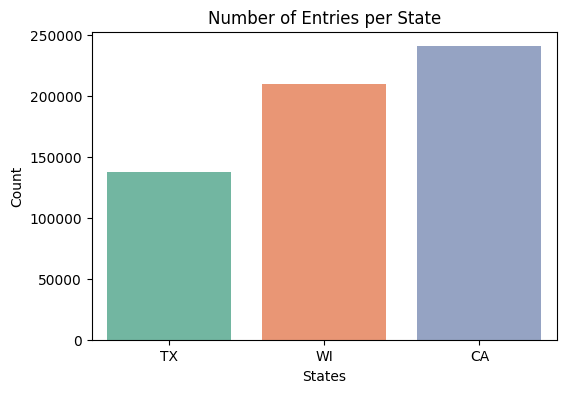

In [ ]:
%matplotlib inline

sales_state_count = df['state_id'].value_counts()
print(sales_state_count)

plt.figure(figsize=(6, 4))
sns.countplot(x='state_id', data=df, palette='Set2')
plt.xlabel('States')
plt.ylabel('Count')
plt.title('Number of Entries per State')
plt.show()


As expected California tops the list due to their high population, but the surprising part is Wisconsin have more attraction than texas even their population is comparatively less.

In [ ]:
data=df.groupby('state_id',as_index=False,sort=False).agg(Total_sale=('sold',np.sum))
data

state_id  Total_sale
0       TX      109263
1       WI      218460
2       CA      415237

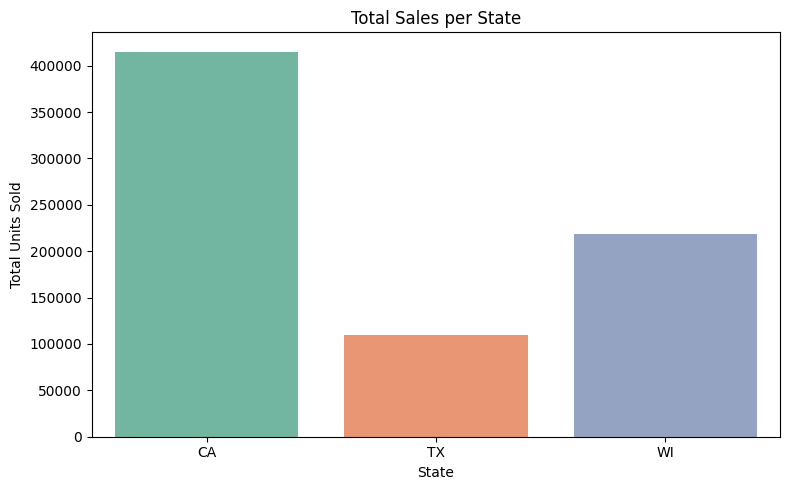

In [ ]:

%matplotlib inline
sales_by_state = df.groupby('state_id', as_index=False).agg(
    Total_sale=('sold', 'sum'))

plt.figure(figsize=(8, 5))
sns.barplot(data=sales_by_state, x='state_id', y='Total_sale', palette='Set2')

plt.xlabel('State')
plt.ylabel('Total Units Sold')
plt.title('Total Sales per State')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
percent_state = df.state_id.value_counts()/df.shape[0] * 100
print(percent_state)

state_id
CA    40.924092
WI    35.643564
TX    23.432343
Name: count, dtype: float64


This graph is directly proportional to number of entries per state, California leads the sales followed by Wisconsin. but the sales in california is almost double to texas and wisconsin

In [ ]:
sales_mean=df.groupby(['state_id','d'],as_index=False,sort=False).agg(mean_sold=('sold',np.mean))
sales_mean

state_id       d  mean_sold
0          TX     d_1   0.901408
1          WI     d_1   0.851852
2          CA     d_1   1.661290
3          TX     d_2   0.619718
4          WI     d_2   0.935185
...       ...     ...        ...
5818       WI  d_1940   1.416667
5819       CA  d_1940   1.854839
5820       TX  d_1941   1.056338
5821       WI  d_1941   1.490741
5822       CA  d_1941   2.330645

[5823 rows x 3 columns]

In [ ]:
kk=sales_mean.groupby('state_id')
ff=kk.groups
CA=sales_mean.iloc[ff['CA']].reset_index()
TX=sales_mean.iloc[ff['TX']].reset_index()
WI=sales_mean.iloc[ff['WI']].reset_index()
TX=TX.drop(columns='index')
CA=CA.drop(columns='index')
WI=WI.drop(columns='index')

In [ ]:
D={'d':(CA['d']),'CA':CA['mean_sold'],'TX':TX['mean_sold'],'WI':WI['mean_sold']}
mean_data=pd.DataFrame(D)

In [ ]:
mean_data

d        CA        TX        WI
0        d_1  1.661290  0.901408  0.851852
1        d_2  1.193548  0.619718  0.935185
2        d_3  1.266129  0.464789  0.870370
3        d_4  0.927419  0.338028  0.703704
4        d_5  1.185484  0.366197  0.398148
...      ...       ...       ...       ...
1936  d_1937  1.250000  0.718310  1.342593
1937  d_1938  1.524194  1.140845  1.240741
1938  d_1939  1.483871  1.056338  1.250000
1939  d_1940  1.854839  1.281690  1.416667
1940  d_1941  2.330645  1.056338  1.490741

[1941 rows x 4 columns]

In [ ]:
%matplotlib inline

fig = px.line(mean_data,x='d', y=mean_data.columns, title='states VS mean sale')
fig.update_xaxes(title_text='days')
fig.update_yaxes(title_text='mean_sold')
fig.show()

We can see California have some higher sales and other two states have similar sales record, also we can note there is no 0 sales with Texas but California and Wisconsion have.

In [ ]:
df[(df["state_id"]=="CA") & (df['d']=='d_1')]['sold'].mean()


np.float64(1.6612903225806452)

In [ ]:
df.groupby(['state_id'],as_index=False,sort=False).agg(unique_store=('store_id',pd.Series.unique))

state_id              unique_store
0       TX        [TX_1, TX_3, TX_2]
1       WI        [WI_1, WI_2, WI_3]
2       CA  [CA_4, CA_3, CA_1, CA_2]

In [ ]:
sales_mean = df.groupby(['store_id', 'd'], as_index=False, sort=False).agg(
    mean_sold=('sold', 'mean'))


In [ ]:
kk=sales_mean.groupby('store_id')
ff=kk.groups
CA_1=sales_mean.iloc[ff['CA_1']].reset_index()
CA_2=sales_mean.iloc[ff['CA_2']].reset_index()
CA_3=sales_mean.iloc[ff['CA_3']].reset_index()
CA_4=sales_mean.iloc[ff['CA_4']].reset_index()

TX_1=sales_mean.iloc[ff['TX_1']].reset_index()
TX_2=sales_mean.iloc[ff['TX_2']].reset_index()
TX_3=sales_mean.iloc[ff['TX_3']].reset_index()

WI_1=sales_mean.iloc[ff['WI_1']].reset_index()
WI_2=sales_mean.iloc[ff['WI_2']].reset_index()
WI_3=sales_mean.iloc[ff['WI_3']].reset_index()

CA_1=CA_1.drop(columns='index')
CA_2=CA_2.drop(columns='index')
CA_3=CA_3.drop(columns='index')
CA_4=CA_4.drop(columns='index')

TX_1=TX_1.drop(columns='index')
TX_2=TX_2.drop(columns='index')
TX_3=TX_3.drop(columns='index')

WI_1=WI_1.drop(columns='index')
WI_2=WI_2.drop(columns='index')
WI_3=WI_3.drop(columns='index')

In [ ]:
print(CA_3)

     store_id       d  mean_sold
0        CA_3     d_1   1.400000
1        CA_3     d_2   1.057143
2        CA_3     d_3   1.514286
3        CA_3     d_4   1.371429
4        CA_3     d_5   1.142857
...       ...     ...        ...
1936     CA_3  d_1937   1.342857
1937     CA_3  d_1938   1.685714
1938     CA_3  d_1939   1.000000
1939     CA_3  d_1940   1.400000
1940     CA_3  d_1941   1.142857

[1941 rows x 3 columns]


In [ ]:
D={'d':(CA_1['d']),'CA_1':CA_1['mean_sold'],'CA_2':CA_2['mean_sold'],'CA_3':CA_3['mean_sold'],'CA_4':CA_4['mean_sold']}
data=pd.DataFrame(D)

In [ ]:

%matplotlib inline
fig = px.line(data,x='d', y=data.columns, title='california stores VS mean sale')
fig.update_xaxes(title_text='days')
fig.update_yaxes(title_text='mean_sold')
fig.show()

we can see store 1 contribtes more sales followed by stoe 3 and also we can see store 2 improved over store 4 over the period of time but they are not significant difference.

In [ ]:
D={'d':(TX_1['d']),'TX_1':TX_1['mean_sold'],'TX_2':TX_2['mean_sold'],'TX_3':TX_3['mean_sold']}
data=pd.DataFrame(D)
data

d  TX_1      TX_2      TX_3
0        d_1  0.35  1.444444  0.750000
1        d_2  0.15  1.185185  0.375000
2        d_3  0.35  0.518519  0.500000
3        d_4  0.45  0.370370  0.208333
4        d_5  0.35  0.555556  0.166667
...      ...   ...       ...       ...
1936  d_1937  0.90  0.518519  0.791667
1937  d_1938  1.15  1.666667  0.541667
1938  d_1939  1.55  1.000000  0.708333
1939  d_1940  1.30  1.777778  0.708333
1940  d_1941  0.55  1.296296  1.208333

[1941 rows x 4 columns]

In [ ]:
%matplotlib inline

fig = px.line(data,x='d', y=data.columns, title='Texas stores VS mean sale')
fig.update_xaxes(title_text='days')
fig.update_yaxes(title_text='mean_sold')
fig.show()

Here store 2 have more sales compared to other store 1 and 3 and they all follow similar patern over the period of time.

In [ ]:
D={'d':(WI_1['d']),'WI_1':WI_1['mean_sold'],'WI_2':WI_2['mean_sold'],'WI_3':WI_3['mean_sold']}
data=pd.DataFrame(D)

In [ ]:
%matplotlib inline
fig = px.line(data,x='d', y=data.columns, title='Wisconsin stores VS mean sale')
fig.update_xaxes(title_text='days')
fig.update_yaxes(title_text='mean_sold')
fig.show()

I can see drop in store 3 performance over the  period of time

In [ ]:
data=df.groupby('store_id',as_index=False,sort=False).agg(Total_sale=('sold',np.sum))
data

store_id  Total_sale
0     TX_1       28098
1     TX_3       22349
2     WI_1       55844
3     WI_2       82983
4     CA_4       48516
5     TX_2       58816
6     CA_3      129623
7     CA_1      199731
8     WI_3       79633
9     CA_2       37367

In [ ]:
%matplotlib inline
px.bar(data, x="store_id", y="Total_sale", color="store_id", title="Total sale in each store",text='Total_sale')


Store 1 in California have the highest sale and the difference is huge compaed to others, it followed by store 3 in california. other stroes have similar sale trend pattern.

In [ ]:
data=df.groupby('cat_id',as_index=False,sort=False).agg(Total_sale=('sold',np.sum))
data

cat_id  Total_sale
0      FOODS      580834
1    HOBBIES       53303
2  HOUSEHOLD      108823

In [ ]:
%matplotlib inline
px.bar(data, x="cat_id", y="Total_sale", color="cat_id", title="Total sale in USA based on each category",text='Total_sale')


We can see the dominance of food category in sales, I thinks because it is FMCG and people need them everyday for survival.

In [ ]:
data=df.groupby(['state_id','cat_id'],as_index=False,sort=False).agg(Total_sale=('sold',np.sum))
data

state_id     cat_id  Total_sale
0       TX      FOODS       64831
1       WI      FOODS      172445
2       CA      FOODS      343558
3       TX    HOBBIES       13483
4       WI    HOBBIES       15106
5       CA    HOBBIES       24714
6       WI  HOUSEHOLD       30909
7       CA  HOUSEHOLD       46965
8       TX  HOUSEHOLD       30949

In [ ]:
data['state_id'] = data.state_id.astype('str')
data['cat_id'] = data.cat_id.astype('str')
data['state_cat_id']=data['state_id']+'_'+data['cat_id']
data

state_id     cat_id  Total_sale  state_cat_id
0       TX      FOODS       64831      TX_FOODS
1       WI      FOODS      172445      WI_FOODS
2       CA      FOODS      343558      CA_FOODS
3       TX    HOBBIES       13483    TX_HOBBIES
4       WI    HOBBIES       15106    WI_HOBBIES
5       CA    HOBBIES       24714    CA_HOBBIES
6       WI  HOUSEHOLD       30909  WI_HOUSEHOLD
7       CA  HOUSEHOLD       46965  CA_HOUSEHOLD
8       TX  HOUSEHOLD       30949  TX_HOUSEHOLD

In [ ]:
%matplotlib inline
px.bar(data, x="state_cat_id", y="Total_sale", color="state_cat_id", title="Total sale in each state based on category",text='Total_sale')


We can confirm the earlier statement as food sales is comparatively higher in all three states.

In [ ]:
data=df.groupby(['month'],as_index=False,sort=False).agg(Total_sale=('sold',np.sum))
data

month  Total_sale
0       1       57650
1       2       64044
2       3       72494
3       4       68866
4       5       70330
5       6       63450
6       7       66848
7       8       68570
8       9       61026
9      10       53514
10     11       46413
11     12       49755

In [ ]:
data['month_name']=['January','February','March','April','May','June','July','August','September','Octobar','November','December']
data

month  Total_sale month_name
0       1       57650    January
1       2       64044   February
2       3       72494      March
3       4       68866      April
4       5       70330        May
5       6       63450       June
6       7       66848       July
7       8       68570     August
8       9       61026  September
9      10       53514    Octobar
10     11       46413   November
11     12       49755   December

In [ ]:
%matplotlib inline
px.bar(data, x="month_name", y="Total_sale", color="month_name", title="Total sale month wise",text='Total_sale')


We can see the sales are dropping a bit in winter months, especially from October to January we can see there is a drop in sales.

In [ ]:
df['event_name_1'].unique()

array(['No_event', 'SuperBowl', 'ValentinesDay', 'PresidentsDay',
       'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End',
       'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day",
       'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [ ]:
data=df.groupby(['event_type_1'],as_index=False).agg(Mean_sale=('sold',np.mean))
data

event_type_1  Mean_sale
0     Cultural   1.281509
1     National   1.073643
2     No_event   1.266966
3    Religious   1.302714
4     Sporting   1.280941

In [ ]:
%matplotlib inline
px.bar(data, x="event_type_1", y="Mean_sale", color="event_type_1", title="Mean sale based on event_type1",text='Mean_sale')


I think except National events there is no distruption in sale due to other events

In [ ]:
data=df.groupby(['event_type_2'],as_index=False).agg(Mean_sale=('sold',np.mean))
data

event_type_2  Mean_sale
0     Cultural   1.454345
1     No_event   1.262921
2    Religious   1.372937

In [ ]:
%matplotlib inline
px.bar(data, x="event_type_2", y="Mean_sale", color="event_type_2", title="Mean sale based on event_type2",text='Mean_sale')


when there is a cultural event the sale is slightly higher copared to religious event and no events.

In [ ]:
data1=df[df['state_id']=='CA'][['sold','snap_CA']]
data1

sold  snap_CA
4          0        0
6          0        0
7          1        0
10         6        0
12         0        0
...      ...      ...
588116     0        0
588117     0        0
588118     1        0
588120     0        0
588121     0        0

[240684 rows x 2 columns]

In [ ]:
data1=data1.groupby(['snap_CA'],as_index=False).agg(Total_sale=('sold',np.sum))
data1

snap_CA  Total_sale
0        0      272279
1        1      142958

In [ ]:
data2=df[df['state_id']=='TX'][['sold','snap_TX']]
data2

sold  snap_TX
0          0        0
1          1        0
5          0        0
15         4        0
22         0        0
...      ...      ...
588109     0        0
588110     0        0
588113     2        0
588115     0        0
588122     0        0

[137811 rows x 2 columns]

In [ ]:
data2=data2.groupby(['snap_TX'],as_index=False).agg(Total_sale=('sold',np.sum))
data2

snap_TX  Total_sale
0        0       70771
1        1       38492

In [ ]:
data3=df[df['state_id']=='WI'][['sold','snap_WI']]
data3

sold  snap_WI
2          0        0
3          0        0
8          0        0
9          3        0
11         0        0
...      ...      ...
588104     1        0
588108     1        0
588111     0        0
588114     0        0
588119     2        0

[209628 rows x 2 columns]

In [ ]:
data3=data3.groupby(['snap_WI'],as_index=False).agg(Total_sale=('sold',np.sum))
data3

snap_WI  Total_sale
0        0      133069
1        1       85391

In [ ]:
%matplotlib inline
dataset_name=["CA","TX","WI"]
d1 = [data1['Total_sale'][0], data2['Total_sale'][0], data3['Total_sale'][0]]
d2 = [data1['Total_sale'][1], data2['Total_sale'][1],data3['Total_sale'][1]]
fig = go.Figure(data=[
    go.Bar(name='No_snap', x=dataset_name, y=d2,text=d2,textposition='auto'),
    go.Bar(name='snap', x=dataset_name, y=d1,text=d1,textposition='auto')
])
fig.update_xaxes(title_text='states')
fig.update_yaxes(title_text='Total sum')
fig.update_layout(barmode='group')
fig.update_layout(title_text='Total sale based on Snap days and Non Snap say')
fig.show()

We can see people across states loves offers and deals, whenever there is snap the sale got signifacantly increases across the states.

In [ ]:
print("Missing values in each column:\n")
print(df.isnull().sum())

Missing values in each column:

id                   0
item_id              0
dept_id              0
cat_id               0
store_id             0
state_id             0
d                    0
sold                 0
date                 0
wm_yr_wk             0
weekday              0
wday                 0
month                0
year                 0
event_name_1         0
event_type_1         0
event_name_2         0
event_type_2         0
snap_CA              0
snap_TX              0
snap_WI              0
sell_price      109501
dtype: int64


Skewness: 2.4417545786869432
Distribution Plot:


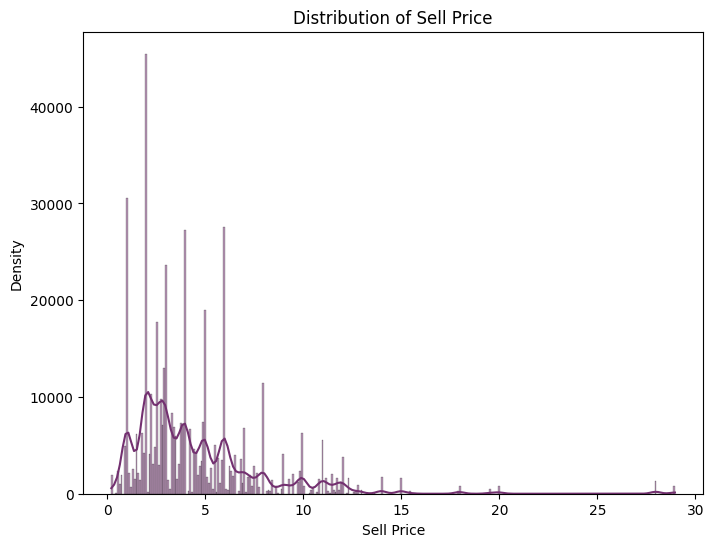

Box Plot:


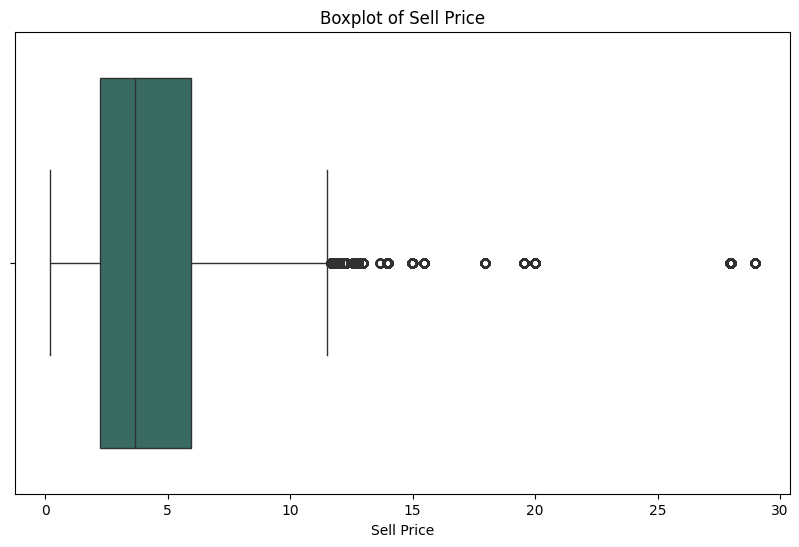

In [ ]:
%matplotlib inline

print("Skewness:", df['sell_price'].skew())

print("Distribution Plot:")
plt.figure(figsize=(8, 6))
sns.histplot(df['sell_price'], kde=True, color="#733070")
plt.title('Distribution of Sell Price')
plt.xlabel('Sell Price')
plt.ylabel('Density')
plt.show()

print("Box Plot:")
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['sell_price'], color="#307368")
plt.title('Boxplot of Sell Price')
plt.xlabel('Sell Price')
plt.show()


In [ ]:
df_filled = df.copy()

We can see missing values in sell_price and the distibution is right skewed, so i imputed values with median values per store and item.

In [ ]:
df_filled['sell_price'] = df_filled['sell_price'].fillna(
    df.groupby(['store_id', 'item_id'])['sell_price'].transform('median')
)

In [ ]:
print("Missing values in each column:\n")
print(df_filled.isnull().sum())

Missing values in each column:

id              0
item_id         0
dept_id         0
cat_id          0
store_id        0
state_id        0
d               0
sold            0
date            0
wm_yr_wk        0
weekday         0
wday            0
month           0
year            0
event_name_1    0
event_type_1    0
event_name_2    0
event_type_2    0
snap_CA         0
snap_TX         0
snap_WI         0
sell_price      0
dtype: int64


In [ ]:
duplicate_count = df_filled.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")
df_filled[df_filled.duplicated()]


Number of duplicate rows: 0


Empty DataFrame
Columns: [id, item_id, dept_id, cat_id, store_id, state_id, d, sold, date, wm_yr_wk, weekday, wday, month, year, event_name_1, event_type_1, event_name_2, event_type_2, snap_CA, snap_TX, snap_WI, sell_price]
Index: []

[0 rows x 22 columns]

In [ ]:
print("\nStatistical Summary:\n")
print(df_filled.describe())


Statistical Summary:

                sold       wm_yr_wk           wday          month  \
count  588123.000000  588123.000000  588123.000000  588123.000000   
mean        1.263273   11343.166924       3.997424       6.334879   
std         5.056924     152.859761       2.000644       3.439202   
min         0.000000   11101.000000       1.000000       1.000000   
25%         0.000000   11218.000000       2.000000       3.000000   
50%         0.000000   11335.000000       4.000000       6.000000   
75%         1.000000   11451.000000       6.000000       9.000000   
max       329.000000   11617.000000       7.000000      12.000000   

                year        snap_CA        snap_TX        snap_WI  \
count  588123.000000  588123.000000  588123.000000  588123.000000   
mean     2013.249356       0.329727       0.329727       0.329727   
std         1.556976       0.470114       0.470114       0.470114   
min      2011.000000       0.000000       0.000000       0.000000   
25%      2


Column: sold
Skewness: 12.962448887458729
Distribution Plot:


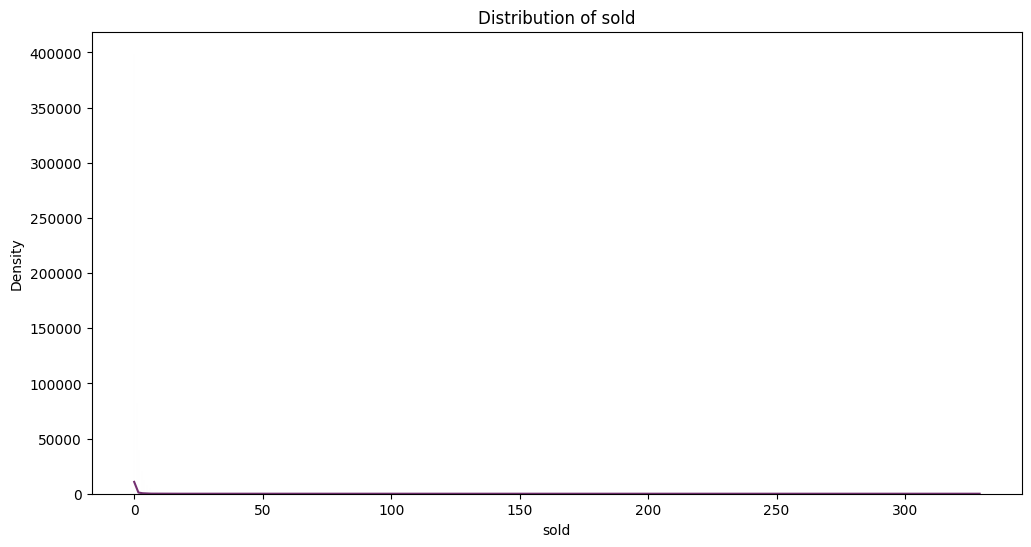

Box Plot:


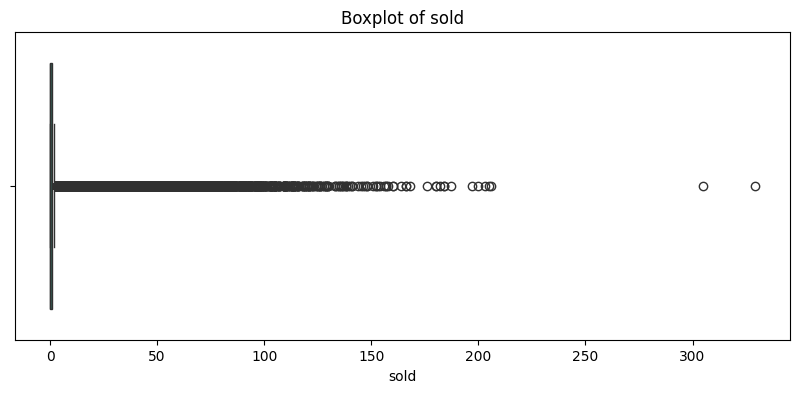


Column: wm_yr_wk
Skewness: 0.041277111756409315
Distribution Plot:


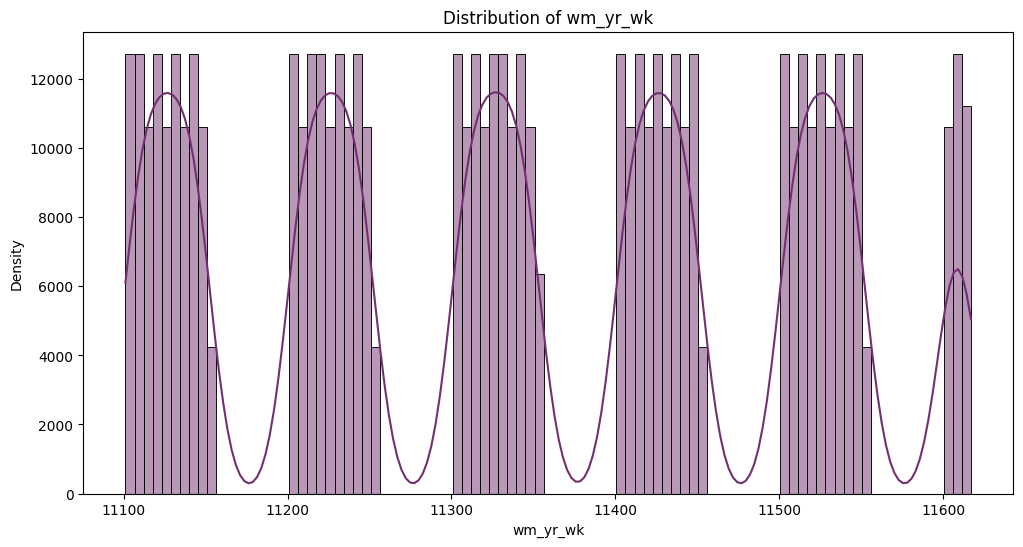

Box Plot:


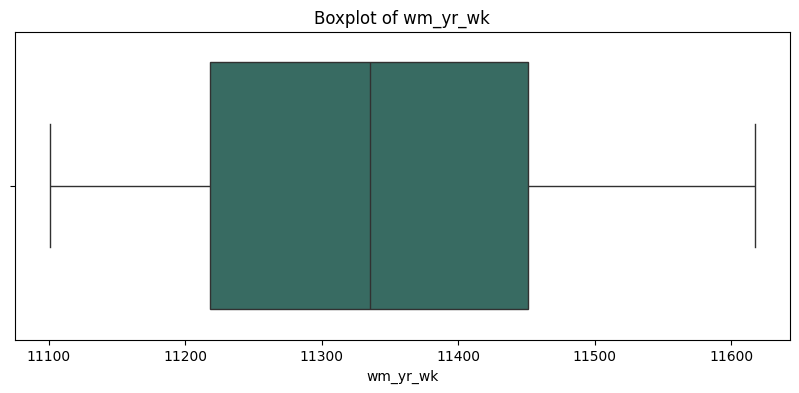


Column: wday
Skewness: 0.001610930692657855
Distribution Plot:


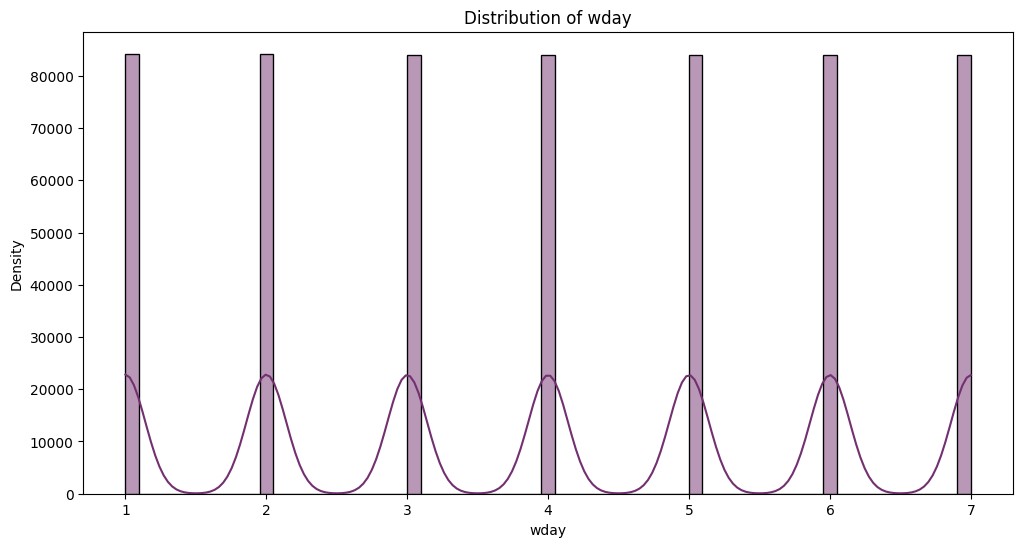

Box Plot:


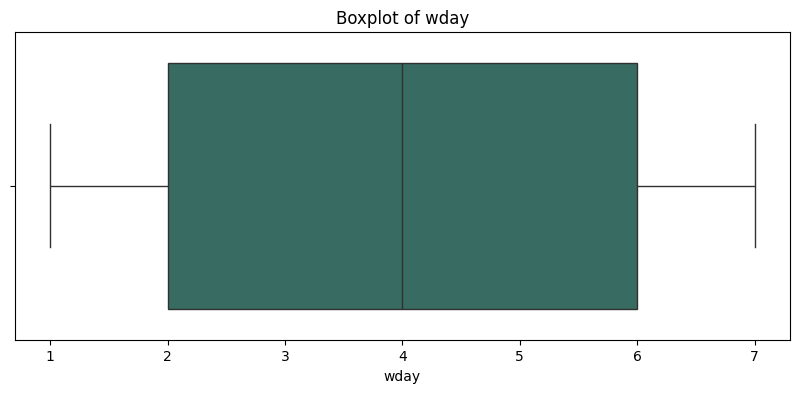


Column: month
Skewness: 0.09103977410464316
Distribution Plot:


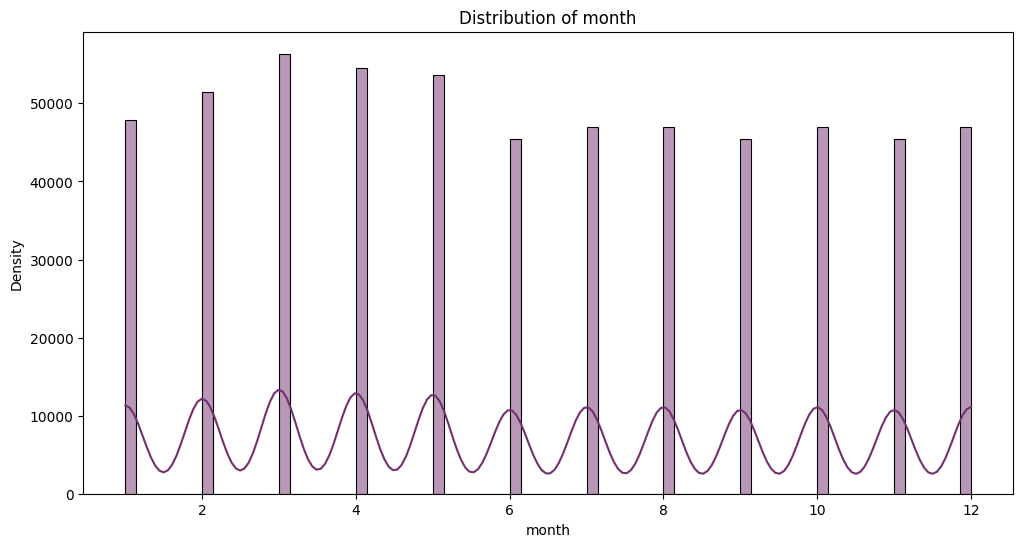

Box Plot:


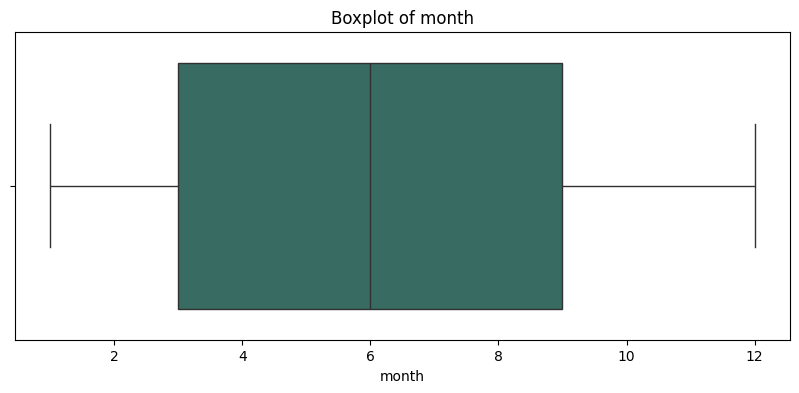


Column: year
Skewness: 0.07289247703293254
Distribution Plot:


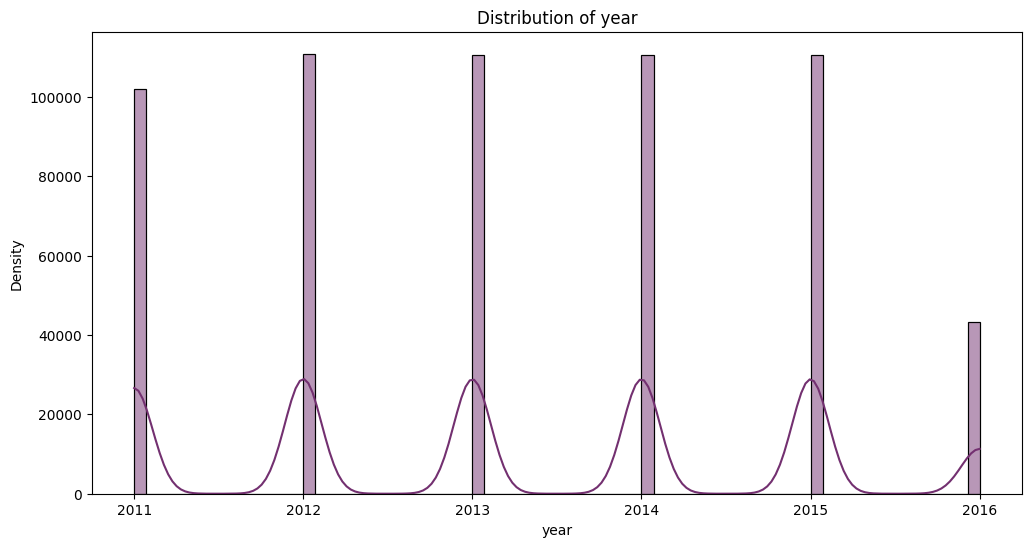

Box Plot:


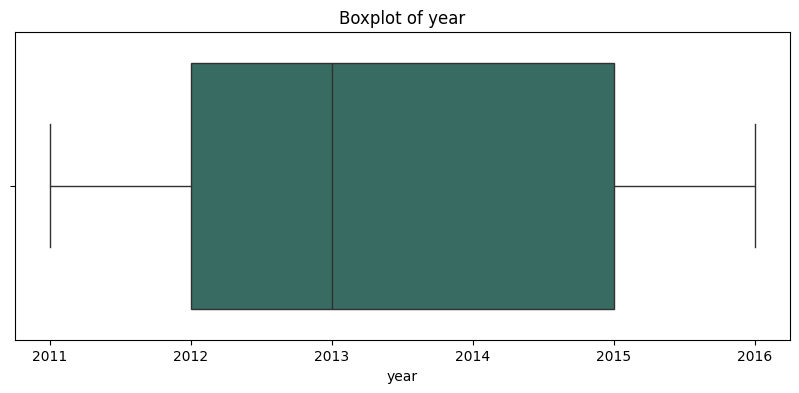


Column: snap_CA
Skewness: 0.7243924777849906
Distribution Plot:


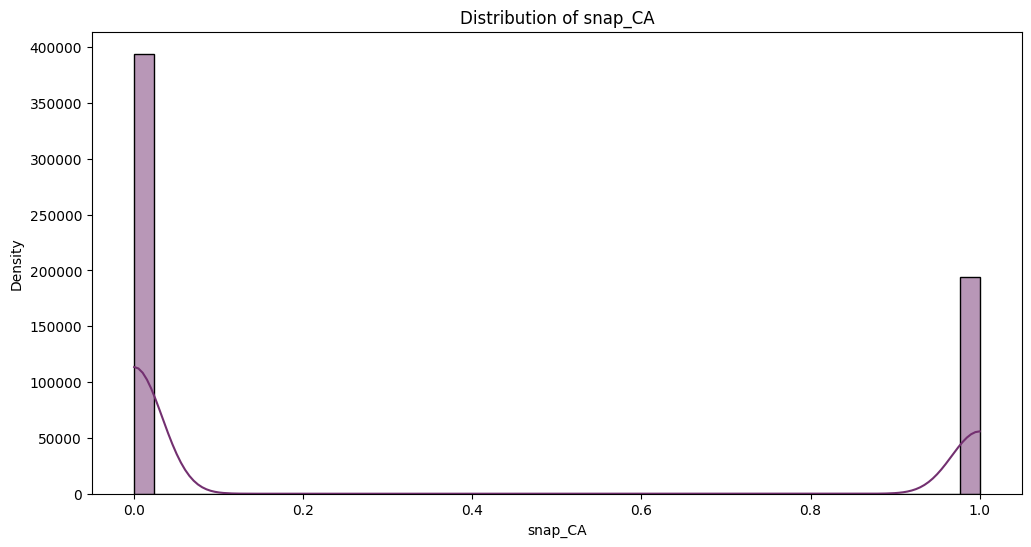

Box Plot:


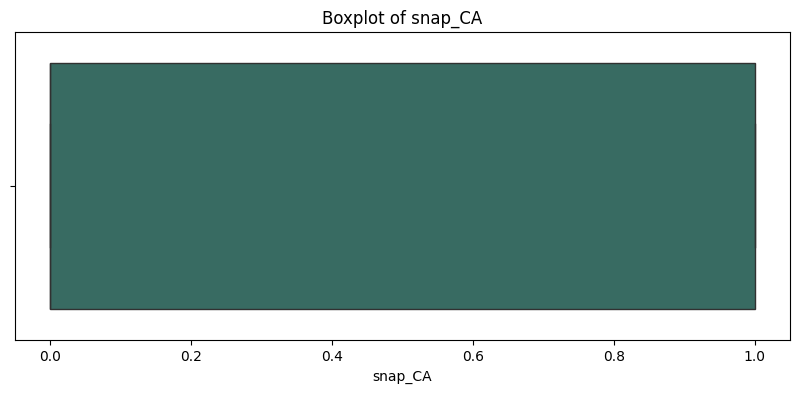


Column: snap_TX
Skewness: 0.7243924777849913
Distribution Plot:


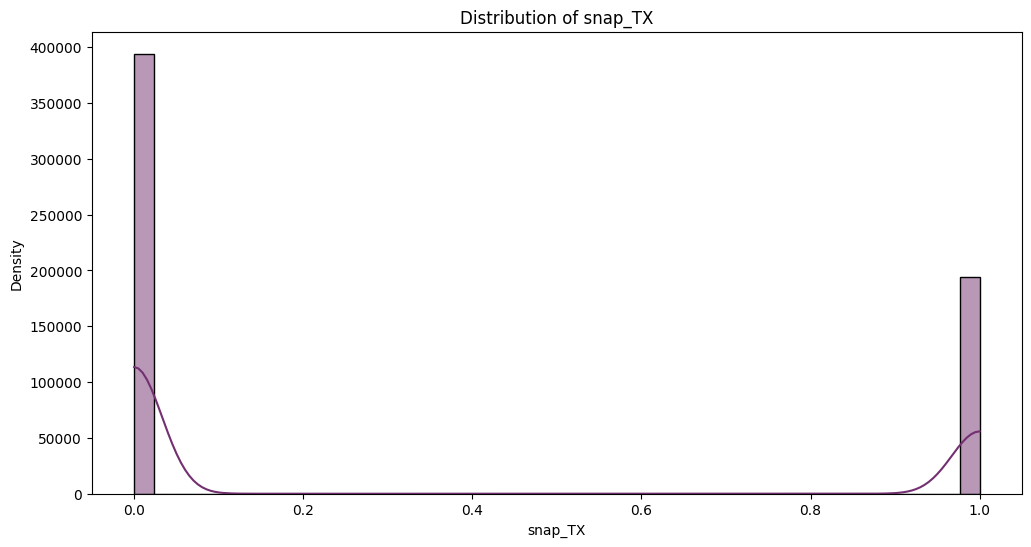

Box Plot:


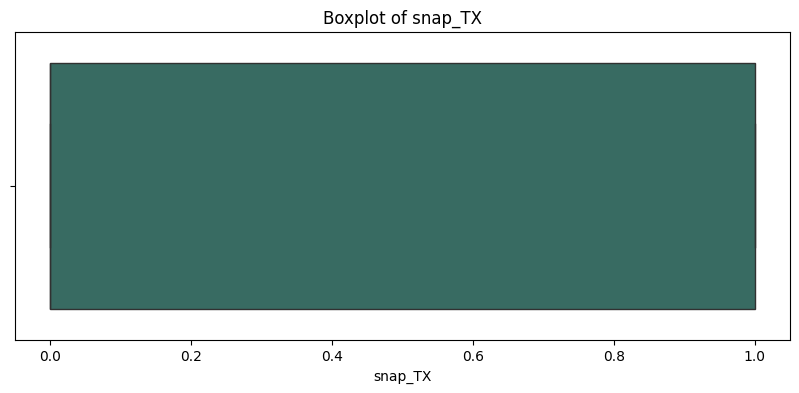


Column: snap_WI
Skewness: 0.7243924777849909
Distribution Plot:


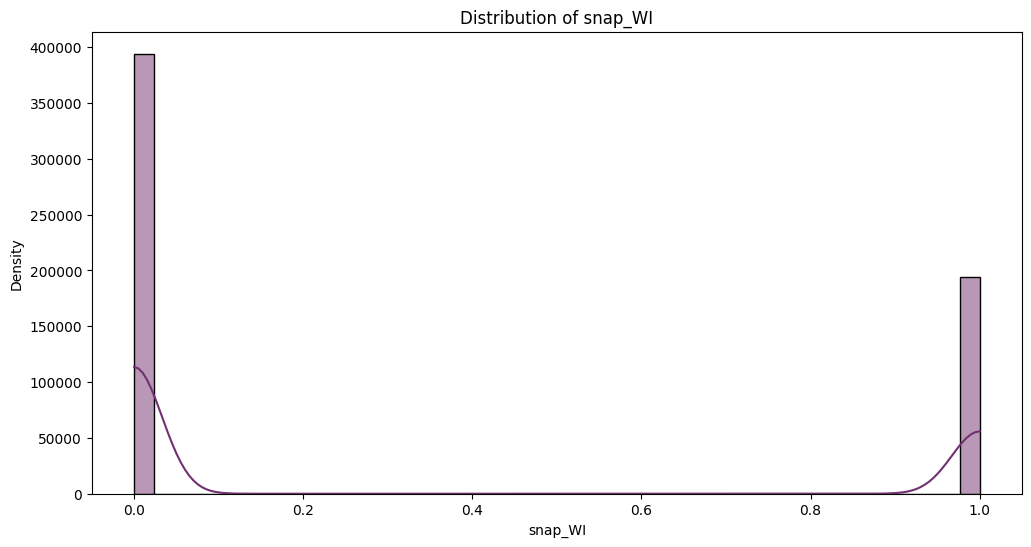

Box Plot:


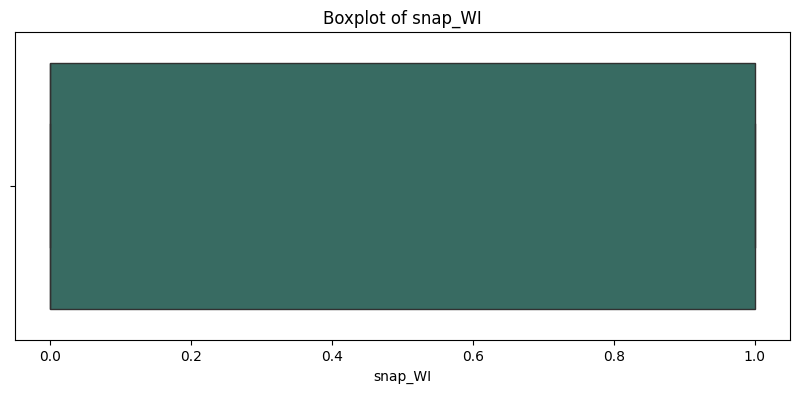


Column: sell_price
Skewness: 2.65515433346668
Distribution Plot:


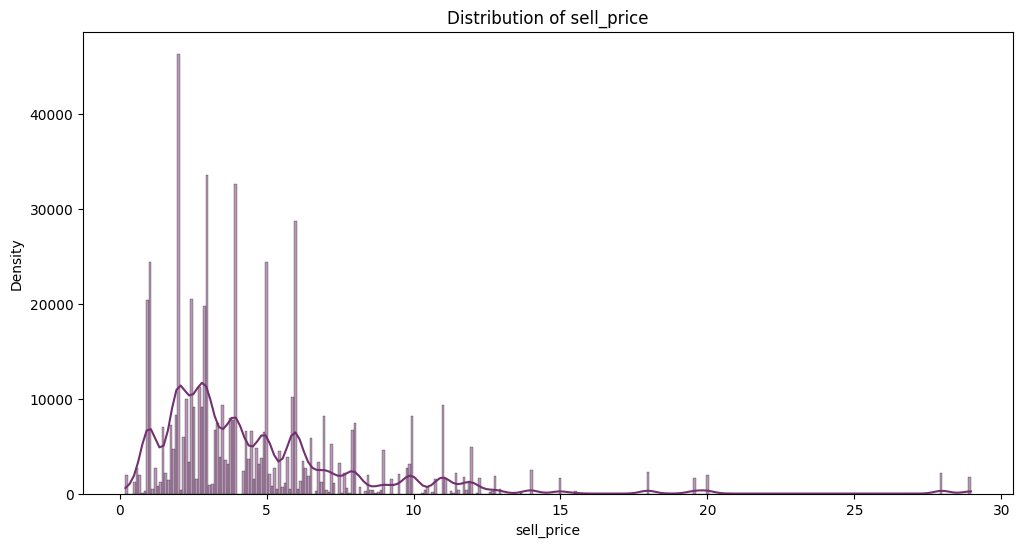

Box Plot:


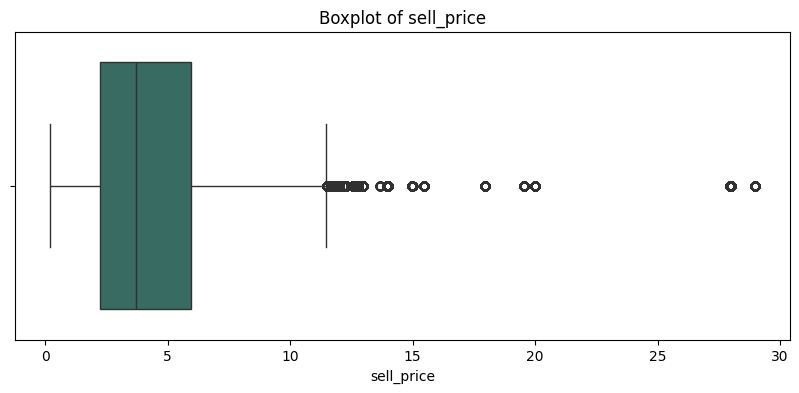

In [ ]:
%matplotlib inline
numeric_cols = df_filled.select_dtypes(include='number').columns

for col in numeric_cols:
    print(f"\nColumn: {col}")
    print(f"Skewness: {df_filled[col].skew()}")

    print("Distribution Plot:")
    plt.figure(figsize=(12, 6))
    sns.histplot(df_filled[col], kde=True, color="#733070")
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

    print("Box Plot:")
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df_filled[col], color="#307368")
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()


In [ ]:
numeric_cols = df_filled.select_dtypes(include='number').columns
z_scores = np.abs(stats.zscore(df_filled[numeric_cols]))
threshold = 3

for i, col in enumerate(numeric_cols):
    outliers_feature = np.sum(z_scores[:, i] > threshold)
    print(f"No of outliers detected in {col}: {outliers_feature}")

outlier_rows = (z_scores > threshold).any(axis=1)
print(f"\nTotal number of outlier rows: {np.sum(outlier_rows)}")

No of outliers detected in sold: 6811
No of outliers detected in wm_yr_wk: 0
No of outliers detected in wday: 0
No of outliers detected in month: 0
No of outliers detected in year: 0
No of outliers detected in snap_CA: 0
No of outliers detected in snap_TX: 0
No of outliers detected in snap_WI: 0
No of outliers detected in sell_price: 9705

Total number of outlier rows: 16516


We have significant outlier count, but the sometimes the oiginal data itself appear to be outlier. we should do domain analysis with SME once. but i will do outlier treatment by applying Standard scaling normalization. Here I did outlier treatment using IQR method instead of replacing them. This treatment ensures the model won't be influenced by extreme values.

In [ ]:
def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df_filled[col].quantile(0.25)
        Q3 = df_filled[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filled[col] = np.where(df_filled[col] < lower_bound, lower_bound,
                           np.where(df_filled[col] > upper_bound, upper_bound, df_filled[col]))
    return df_filled

df_filled = cap_outliers_iqr(df_filled, numeric_cols)

In [ ]:
numeric_cols = df_filled.select_dtypes(include='number').columns
z_scores = np.abs(stats.zscore(df_filled[numeric_cols]))
threshold = 3

for i, col in enumerate(numeric_cols):
    outliers_feature = np.sum(z_scores[:, i] > threshold)
    print(f"No of outliers detected in {col}: {outliers_feature}")

outlier_rows = (z_scores > threshold).any(axis=1)
print(f"\nTotal number of outlier rows: {np.sum(outlier_rows)}")

No of outliers detected in sold: 0
No of outliers detected in wm_yr_wk: 0
No of outliers detected in wday: 0
No of outliers detected in month: 0
No of outliers detected in year: 0
No of outliers detected in snap_CA: 0
No of outliers detected in snap_TX: 0
No of outliers detected in snap_WI: 0
No of outliers detected in sell_price: 0

Total number of outlier rows: 0


In [ ]:
df_filled.head()

id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_2_007_TX_1_evaluation  FOODS_2_007  FOODS_2  FOODS     TX_1       TX   
1  FOODS_3_200_TX_3_evaluation  FOODS_3_200  FOODS_3  FOODS     TX_3       TX   
2  FOODS_3_801_WI_1_evaluation  FOODS_3_801  FOODS_3  FOODS     WI_1       WI   
3  FOODS_3_280_WI_2_evaluation  FOODS_3_280  FOODS_3  FOODS     WI_2       WI   
4  FOODS_2_124_CA_4_evaluation  FOODS_2_124  FOODS_2  FOODS     CA_4       CA   

     d  sold        date  wm_yr_wk  ... month    year  event_name_1  \
0  d_1   0.0  2011-01-29   11101.0  ...   1.0  2011.0      No_event   
1  d_1   1.0  2011-01-29   11101.0  ...   1.0  2011.0      No_event   
2  d_1   0.0  2011-01-29   11101.0  ...   1.0  2011.0      No_event   
3  d_1   0.0  2011-01-29   11101.0  ...   1.0  2011.0      No_event   
4  d_1   0.0  2011-01-29   11101.0  ...   1.0  2011.0      No_event   

   event_type_1 event_name_2 event_type_2 snap_CA snap_TX  snap_WI  sell_price  
0      No_event     No_event     No_event     0.0     0.0      0.0        2.42  
1      No_event     No_event     No_event     0.0     0.0      0.0        2.00  
2      No_event     No_event     No_event     0.0     0.0      0.0        1.00  
3      No_event     No_event     No_event     0.0     0.0      0.0        4.28  
4      No_event     No_event     No_event     0.0     0.0      0.0        2.82  

[5 rows x 22 columns]

In [ ]:
df_filled.head().to_csv('df_filled.csv', index=False)

In [ ]:
df_roll = df_filled.copy()

In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before optimization: {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization: {:.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df_roll = reduce_mem_usage(df_roll)

Memory usage before optimization: 98.71 MB
Memory usage after optimization: 68.43 MB (30.7% reduction)


As this is Time series adding Seasonal and Periodic features to understand the relation.

In [ ]:

f=lambda x: 1 if x==2 or x==3 or x==4 or x==5 else 0
df_roll['is_high_sale_months']=df_roll['month'].map(f)
df_roll

id          item_id      dept_id  \
0           FOODS_2_007_TX_1_evaluation      FOODS_2_007      FOODS_2   
1           FOODS_3_200_TX_3_evaluation      FOODS_3_200      FOODS_3   
2           FOODS_3_801_WI_1_evaluation      FOODS_3_801      FOODS_3   
3           FOODS_3_280_WI_2_evaluation      FOODS_3_280      FOODS_3   
4           FOODS_2_124_CA_4_evaluation      FOODS_2_124      FOODS_2   
...                                 ...              ...          ...   
588118  HOUSEHOLD_1_221_CA_3_evaluation  HOUSEHOLD_1_221  HOUSEHOLD_1   
588119  HOUSEHOLD_1_482_WI_1_evaluation  HOUSEHOLD_1_482  HOUSEHOLD_1   
588120  HOUSEHOLD_2_265_CA_1_evaluation  HOUSEHOLD_2_265  HOUSEHOLD_2   
588121  HOUSEHOLD_1_411_CA_4_evaluation  HOUSEHOLD_1_411  HOUSEHOLD_1   
588122  HOUSEHOLD_1_471_TX_1_evaluation  HOUSEHOLD_1_471  HOUSEHOLD_1   

           cat_id store_id state_id       d  sold        date  wm_yr_wk  ...  \
0           FOODS     TX_1       TX     d_1   0.0  2011-01-29   11104.0  ...   
1           FOODS     TX_3       TX     d_1   1.0  2011-01-29   11104.0  ...   
2           FOODS     WI_1       WI     d_1   0.0  2011-01-29   11104.0  ...   
3           FOODS     WI_2       WI     d_1   0.0  2011-01-29   11104.0  ...   
4           FOODS     CA_4       CA     d_1   0.0  2011-01-29   11104.0  ...   
...           ...      ...      ...     ...   ...         ...       ...  ...   
588118  HOUSEHOLD     CA_3       CA  d_1941   1.0  2016-05-22   11616.0  ...   
588119  HOUSEHOLD     WI_1       WI  d_1941   2.0  2016-05-22   11616.0  ...   
588120  HOUSEHOLD     CA_1       CA  d_1941   0.0  2016-05-22   11616.0  ...   
588121  HOUSEHOLD     CA_4       CA  d_1941   0.0  2016-05-22   11616.0  ...   
588122  HOUSEHOLD     TX_1       TX  d_1941   0.0  2016-05-22   11616.0  ...   

          year  event_name_1  event_type_1  event_name_2 event_type_2 snap_CA  \
0       2011.0      No_event      No_event      No_event     No_event     0.0   
1       2011.0      No_event      No_event      No_event     No_event     0.0   
2       2011.0      No_event      No_event      No_event     No_event     0.0   
3       2011.0      No_event      No_event      No_event     No_event     0.0   
4       2011.0      No_event      No_event      No_event     No_event     0.0   
...        ...           ...           ...           ...          ...     ...   
588118  2016.0      No_event      No_event      No_event     No_event     0.0   
588119  2016.0      No_event      No_event      No_event     No_event     0.0   
588120  2016.0      No_event      No_event      No_event     No_event     0.0   
588121  2016.0      No_event      No_event      No_event     No_event     0.0   
588122  2016.0      No_event      No_event      No_event     No_event     0.0   

       snap_TX snap_WI  sell_price  is_high_sale_months  
0          0.0     0.0    2.419922                    0  
1          0.0     0.0    2.000000                    0  
2          0.0     0.0    1.000000                    0  
3          0.0     0.0    4.281250                    0  
4          0.0     0.0    2.820312                    0  
...        ...     ...         ...                  ...  
588118     0.0     0.0   11.492188                    1  
588119     0.0     0.0    2.960938                    1  
588120     0.0     0.0    4.968750                    1  
588121     0.0     0.0    3.279297                    1  
588122     0.0     0.0    2.740234                    1  

[588123 rows x 23 columns]

In [ ]:
f=lambda x: 1 if x==7 or x==1 or x==2 else 0
df_roll['is_high_sale_day']=df_roll['wday'].map(f)
df_roll

id          item_id      dept_id  \
0           FOODS_2_007_TX_1_evaluation      FOODS_2_007      FOODS_2   
1           FOODS_3_200_TX_3_evaluation      FOODS_3_200      FOODS_3   
2           FOODS_3_801_WI_1_evaluation      FOODS_3_801      FOODS_3   
3           FOODS_3_280_WI_2_evaluation      FOODS_3_280      FOODS_3   
4           FOODS_2_124_CA_4_evaluation      FOODS_2_124      FOODS_2   
...                                 ...              ...          ...   
588118  HOUSEHOLD_1_221_CA_3_evaluation  HOUSEHOLD_1_221  HOUSEHOLD_1   
588119  HOUSEHOLD_1_482_WI_1_evaluation  HOUSEHOLD_1_482  HOUSEHOLD_1   
588120  HOUSEHOLD_2_265_CA_1_evaluation  HOUSEHOLD_2_265  HOUSEHOLD_2   
588121  HOUSEHOLD_1_411_CA_4_evaluation  HOUSEHOLD_1_411  HOUSEHOLD_1   
588122  HOUSEHOLD_1_471_TX_1_evaluation  HOUSEHOLD_1_471  HOUSEHOLD_1   

           cat_id store_id state_id       d  sold        date  wm_yr_wk  ...  \
0           FOODS     TX_1       TX     d_1   0.0  2011-01-29   11104.0  ...   
1           FOODS     TX_3       TX     d_1   1.0  2011-01-29   11104.0  ...   
2           FOODS     WI_1       WI     d_1   0.0  2011-01-29   11104.0  ...   
3           FOODS     WI_2       WI     d_1   0.0  2011-01-29   11104.0  ...   
4           FOODS     CA_4       CA     d_1   0.0  2011-01-29   11104.0  ...   
...           ...      ...      ...     ...   ...         ...       ...  ...   
588118  HOUSEHOLD     CA_3       CA  d_1941   1.0  2016-05-22   11616.0  ...   
588119  HOUSEHOLD     WI_1       WI  d_1941   2.0  2016-05-22   11616.0  ...   
588120  HOUSEHOLD     CA_1       CA  d_1941   0.0  2016-05-22   11616.0  ...   
588121  HOUSEHOLD     CA_4       CA  d_1941   0.0  2016-05-22   11616.0  ...   
588122  HOUSEHOLD     TX_1       TX  d_1941   0.0  2016-05-22   11616.0  ...   

       event_name_1  event_type_1  event_name_2  event_type_2 snap_CA snap_TX  \
0          No_event      No_event      No_event      No_event     0.0     0.0   
1          No_event      No_event      No_event      No_event     0.0     0.0   
2          No_event      No_event      No_event      No_event     0.0     0.0   
3          No_event      No_event      No_event      No_event     0.0     0.0   
4          No_event      No_event      No_event      No_event     0.0     0.0   
...             ...           ...           ...           ...     ...     ...   
588118     No_event      No_event      No_event      No_event     0.0     0.0   
588119     No_event      No_event      No_event      No_event     0.0     0.0   
588120     No_event      No_event      No_event      No_event     0.0     0.0   
588121     No_event      No_event      No_event      No_event     0.0     0.0   
588122     No_event      No_event      No_event      No_event     0.0     0.0   

       snap_WI sell_price  is_high_sale_months  is_high_sale_day  
0          0.0   2.419922                    0                 1  
1          0.0   2.000000                    0                 1  
2          0.0   1.000000                    0                 1  
3          0.0   4.281250                    0                 1  
4          0.0   2.820312                    0                 1  
...        ...        ...                  ...               ...  
588118     0.0  11.492188                    1                 1  
588119     0.0   2.960938                    1                 1  
588120     0.0   4.968750                    1                 1  
588121     0.0   3.279297                    1                 1  
588122     0.0   2.740234                    1                 1  

[588123 rows x 24 columns]

In [ ]:
f=lambda x: 1 if x=='Christmas' else 0
df_roll['is_christmas']=df_roll['event_name_1'].map(f)
df_roll

id          item_id      dept_id  \
0           FOODS_2_007_TX_1_evaluation      FOODS_2_007      FOODS_2   
1           FOODS_3_200_TX_3_evaluation      FOODS_3_200      FOODS_3   
2           FOODS_3_801_WI_1_evaluation      FOODS_3_801      FOODS_3   
3           FOODS_3_280_WI_2_evaluation      FOODS_3_280      FOODS_3   
4           FOODS_2_124_CA_4_evaluation      FOODS_2_124      FOODS_2   
...                                 ...              ...          ...   
588118  HOUSEHOLD_1_221_CA_3_evaluation  HOUSEHOLD_1_221  HOUSEHOLD_1   
588119  HOUSEHOLD_1_482_WI_1_evaluation  HOUSEHOLD_1_482  HOUSEHOLD_1   
588120  HOUSEHOLD_2_265_CA_1_evaluation  HOUSEHOLD_2_265  HOUSEHOLD_2   
588121  HOUSEHOLD_1_411_CA_4_evaluation  HOUSEHOLD_1_411  HOUSEHOLD_1   
588122  HOUSEHOLD_1_471_TX_1_evaluation  HOUSEHOLD_1_471  HOUSEHOLD_1   

           cat_id store_id state_id       d  sold        date  wm_yr_wk  ...  \
0           FOODS     TX_1       TX     d_1   0.0  2011-01-29   11104.0  ...   
1           FOODS     TX_3       TX     d_1   1.0  2011-01-29   11104.0  ...   
2           FOODS     WI_1       WI     d_1   0.0  2011-01-29   11104.0  ...   
3           FOODS     WI_2       WI     d_1   0.0  2011-01-29   11104.0  ...   
4           FOODS     CA_4       CA     d_1   0.0  2011-01-29   11104.0  ...   
...           ...      ...      ...     ...   ...         ...       ...  ...   
588118  HOUSEHOLD     CA_3       CA  d_1941   1.0  2016-05-22   11616.0  ...   
588119  HOUSEHOLD     WI_1       WI  d_1941   2.0  2016-05-22   11616.0  ...   
588120  HOUSEHOLD     CA_1       CA  d_1941   0.0  2016-05-22   11616.0  ...   
588121  HOUSEHOLD     CA_4       CA  d_1941   0.0  2016-05-22   11616.0  ...   
588122  HOUSEHOLD     TX_1       TX  d_1941   0.0  2016-05-22   11616.0  ...   

       event_type_1  event_name_2  event_type_2  snap_CA snap_TX snap_WI  \
0          No_event      No_event      No_event      0.0     0.0     0.0   
1          No_event      No_event      No_event      0.0     0.0     0.0   
2          No_event      No_event      No_event      0.0     0.0     0.0   
3          No_event      No_event      No_event      0.0     0.0     0.0   
4          No_event      No_event      No_event      0.0     0.0     0.0   
...             ...           ...           ...      ...     ...     ...   
588118     No_event      No_event      No_event      0.0     0.0     0.0   
588119     No_event      No_event      No_event      0.0     0.0     0.0   
588120     No_event      No_event      No_event      0.0     0.0     0.0   
588121     No_event      No_event      No_event      0.0     0.0     0.0   
588122     No_event      No_event      No_event      0.0     0.0     0.0   

       sell_price is_high_sale_months  is_high_sale_day  is_christmas  
0        2.419922                   0                 1             0  
1        2.000000                   0                 1             0  
2        1.000000                   0                 1             0  
3        4.281250                   0                 1             0  
4        2.820312                   0                 1             0  
...           ...                 ...               ...           ...  
588118  11.492188                   1                 1             0  
588119   2.960938                   1                 1             0  
588120   4.968750                   1                 1             0  
588121   3.279297                   1                 1             0  
588122   2.740234                   1                 1             0  

[588123 rows x 25 columns]

In [ ]:
df_roll.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'is_high_sale_months',
       'is_high_sale_day', 'is_christmas'],
      dtype='object')

In [ ]:
df_final=df_roll.copy()

Finding lags,rolling window and expanding window to understand the sales trend better.

In [ ]:
lags=[1,7,14,21,28,35,42,49,56,63,70]
for i in tqdm.tqdm(lags):
    df_final['lag_'+str(i)]=df_final.groupby(['id'])['sold'].shift(i)

100%|██████████| 11/11 [00:00<00:00, 14.10it/s]


In [ ]:
df_final.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'is_high_sale_months',
       'is_high_sale_day', 'is_christmas', 'lag_1', 'lag_7', 'lag_14',
       'lag_21', 'lag_28', 'lag_35', 'lag_42', 'lag_49', 'lag_56', 'lag_63',
       'lag_70'],
      dtype='object')

In [ ]:
lags=['lag_1','lag_7', 'lag_14','lag_21', 'lag_28', 'lag_35', 'lag_42', 'lag_49', 'lag_56', 'lag_63','lag_70']
for i in lags:
    df_final[i]=df_final[i].fillna(0)

In [ ]:
window=[7,14,28,35,42]
for i in tqdm.tqdm(window):
    df_final['rolling_mean_'+str(i)]=df_final.groupby(['id'])['sold'].transform(lambda s: s.rolling(i).mean())

100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


In [ ]:
window=['rolling_mean_7','rolling_mean_14', 'rolling_mean_7' ,'rolling_mean_28', 'rolling_mean_35','rolling_mean_42']
for i in window:
    df_final[i]=df_final[i].fillna(0)

In [ ]:
df_final['expanding_mean']=df_final.groupby(['id'])['sold'].transform(lambda s: s.expanding().mean())

In [ ]:
df_final['expanding_mean']=df_final['expanding_mean'].fillna(0)

In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before optimization: {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization: {:.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df_final = reduce_mem_usage(df_final)

Memory usage before optimization: 121.15 MB
Memory usage after optimization: 89.18 MB (26.4% reduction)


Did Labelencoding for categorical variables.

In [ ]:
labelencoder=LabelEncoder()
category=['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id']
for i in tqdm.tqdm(category):
    df_final[i+'_']=labelencoder.fit_transform(df_final[i])

100%|██████████| 10/10 [00:01<00:00,  9.79it/s]


In [ ]:
df_final=df_final.drop(['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id'],axis = 1)

In [ ]:
df_final

d  sold        date  wm_yr_wk   weekday  wday  month    year  \
0          d_1   0.0  2011-01-29   11104.0  Saturday   1.0    1.0  2011.0   
1          d_1   1.0  2011-01-29   11104.0  Saturday   1.0    1.0  2011.0   
2          d_1   0.0  2011-01-29   11104.0  Saturday   1.0    1.0  2011.0   
3          d_1   0.0  2011-01-29   11104.0  Saturday   1.0    1.0  2011.0   
4          d_1   0.0  2011-01-29   11104.0  Saturday   1.0    1.0  2011.0   
...        ...   ...         ...       ...       ...   ...    ...     ...   
588118  d_1941   1.0  2016-05-22   11616.0    Sunday   2.0    5.0  2016.0   
588119  d_1941   2.0  2016-05-22   11616.0    Sunday   2.0    5.0  2016.0   
588120  d_1941   0.0  2016-05-22   11616.0    Sunday   2.0    5.0  2016.0   
588121  d_1941   0.0  2016-05-22   11616.0    Sunday   2.0    5.0  2016.0   
588122  d_1941   0.0  2016-05-22   11616.0    Sunday   2.0    5.0  2016.0   

        snap_CA  snap_TX  ...  event_name_1_  event_type_1_  event_name_2_  \
0           0.0      0.0  ...             19              2              3   
1           0.0      0.0  ...             19              2              3   
2           0.0      0.0  ...             19              2              3   
3           0.0      0.0  ...             19              2              3   
4           0.0      0.0  ...             19              2              3   
...         ...      ...  ...            ...            ...            ...   
588118      0.0      0.0  ...             19              2              3   
588119      0.0      0.0  ...             19              2              3   
588120      0.0      0.0  ...             19              2              3   
588121      0.0      0.0  ...             19              2              3   
588122      0.0      0.0  ...             19              2              3   

        event_type_2_  id_  item_id_  dept_id_  cat_id_  store_id_  state_id_  
0                   1   27        25         1        0          4          1  
1                   1   76        74         2        0          6          1  
2                   1  139       135         2        0          7          2  
3                   1   86        83         2        0          8          2  
4                   1   42        40         1        0          3          0  
...               ...  ...       ...       ...      ...        ...        ...  
588118              1  220       213         5        2          2          0  
588119              1  241       232         5        2          7          2  
588120              1  268       259         6        2          0          0  
588121              1  234       226         5        2          3          0  
588122              1  238       230         5        2          4          1  

[588123 rows x 42 columns]

In [ ]:
l=[]
for i in df_final['d']:
    l.append(i.split('_')[1])
df_final['day']=l
df_final['day']=df_final['day'].astype(np.int16)

In [ ]:

df_final.head(-1)

d  sold        date  wm_yr_wk   weekday  wday  month    year  \
0          d_1   0.0  2011-01-29   11104.0  Saturday   1.0    1.0  2011.0   
1          d_1   1.0  2011-01-29   11104.0  Saturday   1.0    1.0  2011.0   
2          d_1   0.0  2011-01-29   11104.0  Saturday   1.0    1.0  2011.0   
3          d_1   0.0  2011-01-29   11104.0  Saturday   1.0    1.0  2011.0   
4          d_1   0.0  2011-01-29   11104.0  Saturday   1.0    1.0  2011.0   
...        ...   ...         ...       ...       ...   ...    ...     ...   
588117  d_1941   0.0  2016-05-22   11616.0    Sunday   2.0    5.0  2016.0   
588118  d_1941   1.0  2016-05-22   11616.0    Sunday   2.0    5.0  2016.0   
588119  d_1941   2.0  2016-05-22   11616.0    Sunday   2.0    5.0  2016.0   
588120  d_1941   0.0  2016-05-22   11616.0    Sunday   2.0    5.0  2016.0   
588121  d_1941   0.0  2016-05-22   11616.0    Sunday   2.0    5.0  2016.0   

        snap_CA  snap_TX  ...  event_type_1_  event_name_2_  event_type_2_  \
0           0.0      0.0  ...              2              3              1   
1           0.0      0.0  ...              2              3              1   
2           0.0      0.0  ...              2              3              1   
3           0.0      0.0  ...              2              3              1   
4           0.0      0.0  ...              2              3              1   
...         ...      ...  ...            ...            ...            ...   
588117      0.0      0.0  ...              2              3              1   
588118      0.0      0.0  ...              2              3              1   
588119      0.0      0.0  ...              2              3              1   
588120      0.0      0.0  ...              2              3              1   
588121      0.0      0.0  ...              2              3              1   

        id_  item_id_  dept_id_  cat_id_  store_id_  state_id_   day  
0        27        25         1        0          4          1     1  
1        76        74         2        0          6          1     1  
2       139       135         2        0          7          2     1  
3        86        83         2        0          8          2     1  
4        42        40         1        0          3          0     1  
...     ...       ...       ...      ...        ...        ...   ...  
588117  277       268         6        2          2          0  1941  
588118  220       213         5        2          2          0  1941  
588119  241       232         5        2          7          2  1941  
588120  268       259         6        2          0          0  1941  
588121  234       226         5        2          3          0  1941  

[588122 rows x 43 columns]

In [ ]:
df_final=df_final.drop(['d','date'],axis=1)

In [ ]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before optimization: {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization: {:.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df_final = reduce_mem_usage(df_final)

Memory usage before optimization: 81.33 MB
Memory usage after optimization: 43.19 MB (46.9% reduction)


In [ ]:
df_final.shape

(588123, 41)

In [ ]:
df_final.columns

Index(['sold', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'snap_CA',
       'snap_TX', 'snap_WI', 'sell_price', 'is_high_sale_months',
       'is_high_sale_day', 'is_christmas', 'lag_1', 'lag_7', 'lag_14',
       'lag_21', 'lag_28', 'lag_35', 'lag_42', 'lag_49', 'lag_56', 'lag_63',
       'lag_70', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28',
       'rolling_mean_35', 'rolling_mean_42', 'expanding_mean', 'event_name_1_',
       'event_type_1_', 'event_name_2_', 'event_type_2_', 'id_', 'item_id_',
       'dept_id_', 'cat_id_', 'store_id_', 'state_id_', 'day'],
      dtype='object')

With Pearson correlation coefficient, we can find the correlation between two features, if we proceed with correlated features, it will affect the efficiency of the model. 1 is perfect positive corelation, -1 is perfect negative correlation and 0 is non linear correlation.

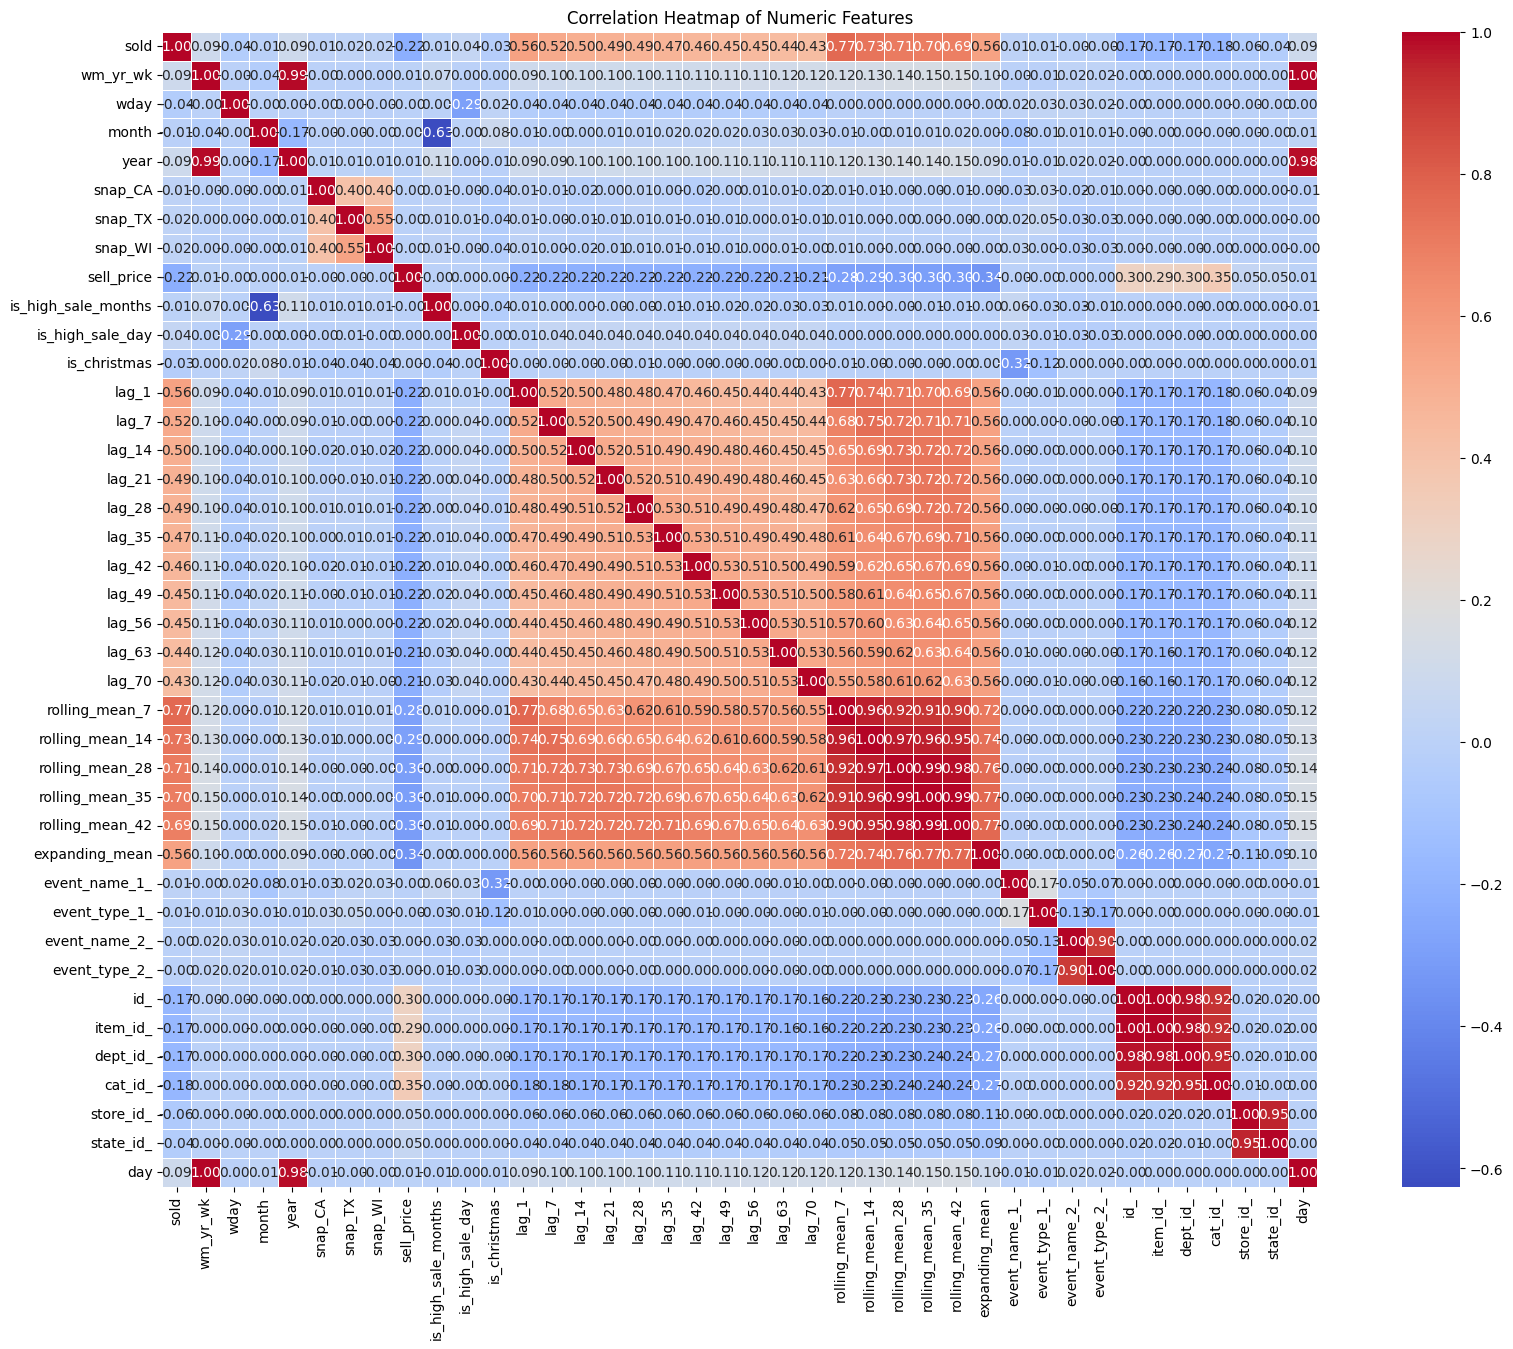

In [ ]:
%matplotlib inline
corr_matrix = df_final.corr(numeric_only=True)
plt.figure(figsize=(22, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [ ]:
top_corr = corr_matrix.unstack().sort_values(ascending=False)
top_corr = top_corr[top_corr != 1].drop_duplicates()
print(top_corr.head(25))


id_              item_id_           0.999986
wm_yr_wk         day                0.995717
rolling_mean_35  rolling_mean_42    0.993831
rolling_mean_28  rolling_mean_35    0.992304
wm_yr_wk         year               0.988685
rolling_mean_42  rolling_mean_28    0.983710
year             day                0.982768
dept_id_         id_                0.976750
item_id_         dept_id_           0.976385
rolling_mean_28  rolling_mean_14    0.968094
rolling_mean_14  rolling_mean_7     0.961233
                 rolling_mean_35    0.956253
store_id_        state_id_          0.950067
cat_id_          dept_id_           0.946882
rolling_mean_14  rolling_mean_42    0.945982
rolling_mean_7   rolling_mean_28    0.923893
cat_id_          id_                0.919934
                 item_id_           0.919192
rolling_mean_35  rolling_mean_7     0.912590
event_type_2_    event_name_2_      0.903652
rolling_mean_7   rolling_mean_42    0.902241
lag_1            rolling_mean_7     0.773445
rolling_me

In [ ]:
data=df_final.copy()


In [ ]:

data.shape

(588123, 41)

In [ ]:
data.head()

sold  wm_yr_wk   weekday  wday  month    year  snap_CA  snap_TX  snap_WI  \
0   0.0   11104.0  Saturday   1.0    1.0  2011.0      0.0      0.0      0.0   
1   1.0   11104.0  Saturday   1.0    1.0  2011.0      0.0      0.0      0.0   
2   0.0   11104.0  Saturday   1.0    1.0  2011.0      0.0      0.0      0.0   
3   0.0   11104.0  Saturday   1.0    1.0  2011.0      0.0      0.0      0.0   
4   0.0   11104.0  Saturday   1.0    1.0  2011.0      0.0      0.0      0.0   

   sell_price  ...  event_type_1_  event_name_2_  event_type_2_  id_  \
0    2.419922  ...              2              3              1   27   
1    2.000000  ...              2              3              1   76   
2    1.000000  ...              2              3              1  139   
3    4.281250  ...              2              3              1   86   
4    2.820312  ...              2              3              1   42   

   item_id_  dept_id_  cat_id_  store_id_  state_id_  day  
0        25         1        0          4          1    1  
1        74         2        0          6          1    1  
2       135         2        0          7          2    1  
3        83         2        0          8          2    1  
4        40         1        0          3          0    1  

[5 rows x 41 columns]

Using LGBM regressor to find feature importance and dro least used correlated columns

In [ ]:
x=data[['wm_yr_wk',  'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'is_high_sale_months', 'is_high_sale_day', 'is_christmas', 'lag_1', 'lag_7', 'lag_14', 'lag_21', 'lag_28', 'lag_35', 'lag_42', 'lag_49', 'lag_56', 'lag_63', 'lag_70', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28', 'rolling_mean_35', 'rolling_mean_42', 'expanding_mean', 'event_name_1_', 'event_type_1_', 'event_name_2_', 'event_type_2_', 'id_', 'item_id_', 'dept_id_', 'cat_id_', 'store_id_', 'state_id_','day']]


In [ ]:

y=data[['day','sold']]

In [ ]:
x_train = x.loc[x['day'] <= 1678]
x_val_cv = x.loc[(x['day'] > 1678) & (x['day'] <= 1913)]
x_test = x.loc[x['day'] >= 1914]

In [ ]:
y_train = y.loc[y['day'] <= 1678]
y_val_cv = y.loc[(y['day'] > 1678) & (y['day'] <= 1913)]
y_test = y.loc[y['day'] >= 1914]

In [ ]:
model = LGBMRegressor()
model.fit(x_train, y_train['sold'])

importances = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(importances.head(10))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 508434, number of used features: 39
[LightGBM] [Info] Start training from score 0.543384
rolling_mean_7     520
lag_1              281
expanding_mean     245
rolling_mean_14    180
id_                176
wday               165
sell_price         143
rolling_mean_42    133
day                110
rolling_mean_35    110
dtype: int32


In [ ]:
threshold = 0.9
groups = []
corr_columns = set()

for col in corr_matrix.columns:
    high_corr = corr_matrix.index[(corr_matrix[col] > threshold) & (corr_matrix[col] < 1.0)].tolist()
    if high_corr:
        group = list(set([col] + high_corr))
        if not any(set(group).issubset(set(g)) for g in groups):
            groups.append(group)
            corr_columns.update(group)


In [ ]:
to_keep = []
to_drop = []

for group in groups:
    best = importances[group].idxmax()
    to_keep.append(best)
    to_drop.extend([f for f in group if f != best])

print("Keeping:", to_keep)
print("Dropping:", to_drop)


Keeping: ['day', 'rolling_mean_7', 'event_name_2_', 'id_', 'store_id_']
Dropping: ['wm_yr_wk', 'year', 'rolling_mean_35', 'rolling_mean_28', 'rolling_mean_14', 'rolling_mean_42', 'event_type_2_', 'item_id_', 'cat_id_', 'dept_id_', 'state_id_']


In [ ]:
data.shape

(588123, 41)

In [ ]:
data=data.drop(['weekday','year', 'wm_yr_wk', 'rolling_mean_42', 'rolling_mean_14', 'rolling_mean_35', 'event_type_1_','rolling_mean_28', 'event_type_2_', 'item_id_', 'cat_id_', 'dept_id_', 'state_id_'],axis = 1)


In [ ]:
data.columns

Index(['sold', 'wday', 'month', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price',
       'is_high_sale_months', 'is_high_sale_day', 'is_christmas', 'lag_1',
       'lag_7', 'lag_14', 'lag_21', 'lag_28', 'lag_35', 'lag_42', 'lag_49',
       'lag_56', 'lag_63', 'lag_70', 'rolling_mean_7', 'expanding_mean',
       'event_name_1_', 'event_name_2_', 'id_', 'store_id_', 'day'],
      dtype='object')

In [ ]:
data

sold  wday  month  snap_CA  snap_TX  snap_WI  sell_price  \
0        0.0   1.0    1.0      0.0      0.0      0.0    2.419922   
1        1.0   1.0    1.0      0.0      0.0      0.0    2.000000   
2        0.0   1.0    1.0      0.0      0.0      0.0    1.000000   
3        0.0   1.0    1.0      0.0      0.0      0.0    4.281250   
4        0.0   1.0    1.0      0.0      0.0      0.0    2.820312   
...      ...   ...    ...      ...      ...      ...         ...   
588118   1.0   2.0    5.0      0.0      0.0      0.0   11.492188   
588119   2.0   2.0    5.0      0.0      0.0      0.0    2.960938   
588120   0.0   2.0    5.0      0.0      0.0      0.0    4.968750   
588121   0.0   2.0    5.0      0.0      0.0      0.0    3.279297   
588122   0.0   2.0    5.0      0.0      0.0      0.0    2.740234   

        is_high_sale_months  is_high_sale_day  is_christmas  ...  lag_56  \
0                         0                 1             0  ...     0.0   
1                         0                 1             0  ...     0.0   
2                         0                 1             0  ...     0.0   
3                         0                 1             0  ...     0.0   
4                         0                 1             0  ...     0.0   
...                     ...               ...           ...  ...     ...   
588118                    1                 1             0  ...     0.0   
588119                    1                 1             0  ...     0.0   
588120                    1                 1             0  ...     0.0   
588121                    1                 1             0  ...     0.0   
588122                    1                 1             0  ...     1.0   

        lag_63  lag_70  rolling_mean_7  expanding_mean  event_name_1_  \
0          0.0     0.0        0.000000        0.000000             19   
1          0.0     0.0        0.000000        1.000000             19   
2          0.0     0.0        0.000000        0.000000             19   
3          0.0     0.0        0.000000        0.000000             19   
4          0.0     0.0        0.000000        0.000000             19   
...        ...     ...             ...             ...            ...   
588118     2.5     1.0        0.714355        0.457764             19   
588119     1.0     1.0        1.500000        0.704590             19   
588120     0.0     1.0        0.428467        0.349365             19   
588121     0.0     0.0        1.213867        0.852539             19   
588122     1.0     0.0        0.571289        0.468262             19   

        event_name_2_  id_  store_id_   day  
0                   3   27          4     1  
1                   3   76          6     1  
2                   3  139          7     1  
3                   3   86          8     1  
4                   3   42          3     1  
...               ...  ...        ...   ...  
588118              3  220          2  1941  
588119              3  241          7  1941  
588120              3  268          0  1941  
588121              3  234          3  1941  
588122              3  238          4  1941  

[588123 rows x 28 columns]

Since  this is a time series forecast I will be giving importance to Seasons and Periodic data. As we saw earlier events and day have a significant contribution towards target variable 'sold'

In [ ]:
x=data[['wday', 'month', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price',
       'is_high_sale_months', 'is_high_sale_day', 'is_christmas', 'lag_1',
       'lag_7', 'lag_14', 'lag_21', 'lag_28', 'lag_35', 'lag_42', 'lag_49',
       'lag_56', 'lag_63', 'lag_70', 'rolling_mean_7', 'expanding_mean',
       'event_name_1_', 'event_name_2_', 'id_', 'store_id_', 'day']]

In [ ]:
y=data[['day','sold']]

### Models Used
* Lasso regression (linear with l1 regularization)
* Ridge model (linear with l2 regularization)
* Decision Tree (non-linear tree)
* LightGBM (gradient boost)


###  To make sure model is robust beyond fixed train and test split
* Dataset was divided into train, test and validation set.
* Used performance metrics like RMSE, MAE, R^2, RMSSE
* Performed cross validation on all models, using 3 splits of time data folds and return RMSE and R^2 along with mean and standard deviation.

### Lasso Regression
This falls under regression - supervised learning. it have parameters alpha with l1 regularization strength and we tested with different values. this uses standard scaling data. this parameter controls the coefficient and perform feature selection and prevents overfitting.

### Ridge regression
This also falls under regression - supervised learning. it have parameters alpha with l2 regularization strength and we tested with different values. this uses standard scaling data. this parameter controls the coefficient and perform feature selection and prevents overfitting. the main difference is it produce smooth coefficient without zeroing.

### LGBM regression
This also falls under regression - supervised learning but use Gradient boost decision trees. it have parameters like num_leaves is the quanity of maximum number of leaves per tree that is being used to control the model's complexity; big numbers can increase the accuracy but also the risk of overfitting. max_depth is the, Tree's maximum depth, which is limited to improve the model's ability in generalization. learning rate is the rate at which learning occurs and reduced in each step,n_ estimators is number of trees, this is highly effective for non-linear relations.

### Decision tree
This also falls under regression - supervised learning and it used tree like model that recursively split the data into feature values and minimize error and improve accuracy. we have parameters like max_depth, min_samples_split and minsample_leaf,set random state as 0 for reproducibilty. but for our case this model didn't performed well compared to others so I will be using only the other three for Hyperpaameter tuning.

In [ ]:
x_train = x.loc[x['day'] <= 1678]
x_val_cv = x.loc[(x['day'] > 1678) & (x['day'] <= 1913)]
x_test = x.loc[x['day'] >= 1914]

In [ ]:
y_train = y.loc[y['day'] <= 1678]
y_val_cv = y.loc[(y['day'] > 1678) & (y['day'] <= 1913)]
y_test = y.loc[y['day'] >= 1914]

In [ ]:
print("x_train {}".format(x_train.shape))
print("\nx_test {}".format(x_test.shape))

x_train (508434, 27)

x_test (8484, 27)


In [ ]:
print("y_train {}".format(y_train.shape))
print("\ny_test {}".format(y_test.shape))

y_train (508434, 2)

y_test (8484, 2)


In [ ]:
x_train.head()

wday  month  snap_CA  snap_TX  snap_WI  sell_price  is_high_sale_months  \
0   1.0    1.0      0.0      0.0      0.0    2.419922                    0   
1   1.0    1.0      0.0      0.0      0.0    2.000000                    0   
2   1.0    1.0      0.0      0.0      0.0    1.000000                    0   
3   1.0    1.0      0.0      0.0      0.0    4.281250                    0   
4   1.0    1.0      0.0      0.0      0.0    2.820312                    0   

   is_high_sale_day  is_christmas  lag_1  ...  lag_56  lag_63  lag_70  \
0                 1             0    0.0  ...     0.0     0.0     0.0   
1                 1             0    0.0  ...     0.0     0.0     0.0   
2                 1             0    0.0  ...     0.0     0.0     0.0   
3                 1             0    0.0  ...     0.0     0.0     0.0   
4                 1             0    0.0  ...     0.0     0.0     0.0   

   rolling_mean_7  expanding_mean  event_name_1_  event_name_2_  id_  \
0             0.0             0.0             19              3   27   
1             0.0             1.0             19              3   76   
2             0.0             0.0             19              3  139   
3             0.0             0.0             19              3   86   
4             0.0             0.0             19              3   42   

   store_id_  day  
0          4    1  
1          6    1  
2          7    1  
3          8    1  
4          3    1  

[5 rows x 27 columns]

In [ ]:
x_test.head()

wday  month  snap_CA  snap_TX  snap_WI  sell_price  \
579639   3.0    4.0      0.0      0.0      0.0    2.980469   
579640   3.0    4.0      0.0      0.0      0.0    2.000000   
579641   3.0    4.0      0.0      0.0      0.0    1.000000   
579642   3.0    4.0      0.0      0.0      0.0    4.281250   
579643   3.0    4.0      0.0      0.0      0.0    2.980469   

        is_high_sale_months  is_high_sale_day  is_christmas  lag_1  ...  \
579639                    1                 0             0    1.0  ...   
579640                    1                 0             0    2.0  ...   
579641                    1                 0             0    2.0  ...   
579642                    1                 0             0    0.0  ...   
579643                    1                 0             0    2.0  ...   

        lag_56  lag_63  lag_70  rolling_mean_7  expanding_mean  event_name_1_  \
579639     0.0     0.0     0.0        0.142822        0.139282             19   
579640     1.0     2.5     2.0        1.213867        0.714355             19   
579641     2.0     1.0     0.0        1.428711        1.005859             19   
579642     1.0     0.0     0.0        0.142822        0.203979             19   
579643     0.0     1.0     0.0        0.285645        0.436035             19   

        event_name_2_  id_  store_id_   day  
579639              3   27          4  1914  
579640              3   76          6  1914  
579641              3  139          7  1914  
579642              3   86          8  1914  
579643              3   42          3  1914  

[5 rows x 27 columns]

In [ ]:
y_train = y_train.drop(columns=['day'])
y_val_cv = y_val_cv.drop(columns=['day'])
y_test = y_test.drop(columns=['day'])

In [ ]:
print("y_train {}".format(y_train.shape))
print("\ny_test {}".format(y_test.shape))

y_train (508434, 1)

y_test (8484, 1)


Lasso

In [ ]:
clf = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
clf.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1))])

In [ ]:
y_predicted=clf.predict(x_test)

In [ ]:
y_predicted.shape

(8484,)

In [ ]:
y_test['sold'].shape

(8484,)

In [ ]:
MSE = mean_squared_error(y_test['sold'], y_predicted)
print(f'MSE using Linear Regression with L1 (Lasso): {MSE:.4f}')

RMSE = np.sqrt(MSE)
print(f'RMSE using Linear Regression with L1 (Lasso): {RMSE:.4f}')

MAE = mean_absolute_error(y_test['sold'], y_predicted)
print(f'MAE using Linear Regression with L1 (Lasso): {MAE:.4f}')

R2 = r2_score(y_test['sold'], y_predicted)
print(f'R^2 using Linear Regression with L1 (Lasso): {R2:.4f}')


def rmsse(y_true, y_pred, y_train):

    n = len(y_train)
    denominator = np.mean(np.diff(y_train.values.ravel())**2)
    numerator = mean_squared_error(y_true, y_pred)
    return np.sqrt(numerator / denominator)

RMSSE = rmsse(y_test['sold'], y_predicted, y_train['sold'])
print(f'RMSSE using Linear Regression with L1 (Lasso): {RMSSE:.4f}')



MSE using Linear Regression with L1 (Lasso): 0.4500
RMSE using Linear Regression with L1 (Lasso): 0.6708
MAE using Linear Regression with L1 (Lasso): 0.5211
R^2 using Linear Regression with L1 (Lasso): 0.5016
RMSSE using Linear Regression with L1 (Lasso): 0.5469


In [ ]:
y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

rmse_train = np.sqrt(mean_squared_error(y_train['sold'], y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test['sold'], y_pred_test))

print(f"Training RMSE using Linear Regression with L1 (Lasso): {rmse_train:.4f}")
print(f"Test RMSE using Linear Regression with L1 (Lasso): {rmse_test:.4f}")


Training RMSE using Linear Regression with L1 (Lasso): 0.5760
Test RMSE using Linear Regression with L1 (Lasso): 0.6708


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)


In [ ]:
def cross_val_metrics(model, X, y, cv_splits=3):
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    cv_rmse_list = []
    cv_r2_list = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train.values.ravel())
        y_val_pred = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        r2 = r2_score(y_val, y_val_pred)
        cv_rmse_list.append(rmse)
        cv_r2_list.append(r2)

        print(f"Fold {fold+1}: RMSE={rmse:.4f}, R^2={r2:.4f}")

    print(f"\nTimeSeries Cross-Validation RMSE: {np.mean(cv_rmse_list):.4f} ± {np.std(cv_rmse_list):.4f}")
    print(f"TimeSeries Cross-Validation R^2  : {np.mean(cv_r2_list):.4f} ± {np.std(cv_r2_list):.4f}")

    return cv_rmse_list, cv_r2_list


In [ ]:
lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
cross_val_metrics(lasso, x_train, y_train)


Fold 1: RMSE=0.5557, R^2=0.6165
Fold 2: RMSE=0.6039, R^2=0.5623
Fold 3: RMSE=0.6292, R^2=0.5294

TimeSeries Cross-Validation RMSE: 0.5962 ± 0.0305
TimeSeries Cross-Validation R^2  : 0.5694 ± 0.0359


([np.float64(0.5556960540840761),
  np.float64(0.6038746429502315),
  np.float64(0.6291679643360759)],
 [0.6164892315864563, 0.5623492002487183, 0.5294378995895386])

In [ ]:
x_train = x.loc[x['day'] <= 1678]
x_val_cv = x.loc[(x['day'] > 1678) & (x['day'] <= 1913)]
x_test = x.loc[x['day'] >= 1914]

In [ ]:

x_train.shape


(508434, 27)

Ridge

In [ ]:
ridge = make_pipeline(StandardScaler(), Ridge(alpha=0.1))
ridge.fit(x_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.1))])

In [ ]:
y_pred_ridge = ridge.predict(x_test)

In [ ]:
y_test['sold'].shape

(8484,)

In [ ]:

MSE = mean_squared_error(y_test['sold'], y_pred_ridge)
print(f'MSE using Linear Regression with L2 (Ridge): {MSE:.4f}')

RMSE = np.sqrt(MSE)
print(f'RMSE using Linear Regression with L2 (Ridge): {RMSE:.4f}')

MAE = mean_absolute_error(y_test['sold'], y_pred_ridge)
print(f'MAE using Linear Regression with L2 (Ridge): {MAE:.4f}')

R2 = r2_score(y_test['sold'], y_pred_ridge)
print(f'R^2 using Linear Regression with L2 (Ridge): {R2:.4f}')

def rmsse(y_true, y_pred, y_train):
    n = len(y_train)
    denominator = np.mean(np.diff(y_train.values.ravel())**2)
    numerator = mean_squared_error(y_true, y_pred)
    return np.sqrt(numerator / denominator)

rmsse_ridge = rmsse(y_test['sold'], y_pred_ridge, y_train['sold'])
print(f'RMSSE using Linear Regression with L2 (Ridge): {rmsse_ridge:.4f}')


MSE using Linear Regression with L2 (Ridge): 0.4315
RMSE using Linear Regression with L2 (Ridge): 0.6568
MAE using Linear Regression with L2 (Ridge): 0.4831
R^2 using Linear Regression with L2 (Ridge): 0.5221
RMSSE using Linear Regression with L2 (Ridge): 0.5356


In [ ]:
ridge = make_pipeline(StandardScaler(), Ridge(alpha=0.1))
cross_val_metrics(ridge, x_train, y_train)


Fold 1: RMSE=0.5429, R^2=0.6339
Fold 2: RMSE=0.5909, R^2=0.5810
Fold 3: RMSE=0.6154, R^2=0.5498

TimeSeries Cross-Validation RMSE: 0.5831 ± 0.0301
TimeSeries Cross-Validation R^2  : 0.5882 ± 0.0347


([np.float64(0.5429336756073904),
  np.float64(0.5908630103453761),
  np.float64(0.6153772823935333)],
 [0.6339027881622314, 0.5810059905052185, 0.5498402714729309])

Decision Tree

In [ ]:
clf=DecisionTreeRegressor(random_state=0)
clf.fit(x_train,y_train)

DecisionTreeRegressor(random_state=0)

In [ ]:
y_predicted=clf.predict(x_test)


In [ ]:
y_test['sold'].shape


(8484,)

In [ ]:


MSE = mean_squared_error(y_test['sold'], y_predicted)
print(f'MSE using DecisionTreeRegressor: {MSE:.4f}')

RMSE = np.sqrt(MSE)
print(f'RMSE using DecisionTreeRegressor: {RMSE:.4f}')

MAE = mean_absolute_error(y_test['sold'], y_predicted)
print(f'MAE using DecisionTreeRegressor: {MAE:.4f}')

R2 = r2_score(y_test['sold'], y_predicted)
print(f'R^2 using DecisionTreeRegressor: {R2:.4f}')

def rmsse(y_true, y_pred, y_train):

    n = len(y_train)
    denominator = np.mean(np.diff(y_train.values.ravel())**2)
    numerator = mean_squared_error(y_true, y_pred)
    return np.sqrt(numerator / denominator)

RMSSE = rmsse(y_test['sold'], y_predicted, y_train['sold'])
print(f'RMSSE using DecisionTreeRegressor: {RMSSE:.4f}')


MSE using DecisionTreeRegressor: 0.9552
RMSE using DecisionTreeRegressor: 0.9773
MAE using DecisionTreeRegressor: 0.6096
R^2 using DecisionTreeRegressor: -0.0581
RMSSE using DecisionTreeRegressor: 0.7969


In [ ]:
dt = DecisionTreeRegressor(random_state=42)
cross_val_metrics(dt, x_train, y_train)

Fold 1: RMSE=0.7980, R^2=0.2092
Fold 2: RMSE=0.8807, R^2=0.0690
Fold 3: RMSE=0.9227, R^2=-0.0121

TimeSeries Cross-Validation RMSE: 0.8671 ± 0.0518
TimeSeries Cross-Validation R^2  : 0.0887 ± 0.0914


([np.float64(0.7979783949671677),
  np.float64(0.8807375423459906),
  np.float64(0.9227059243007587)],
 [0.20916615002106387, 0.06904814869183484, -0.01206967158062855])

In [ ]:
x_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 508434 entries, 0 to 508433
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   wday                 508434 non-null  float16
 1   month                508434 non-null  float16
 2   snap_CA              508434 non-null  float16
 3   snap_TX              508434 non-null  float16
 4   snap_WI              508434 non-null  float16
 5   sell_price           508434 non-null  float16
 6   is_high_sale_months  508434 non-null  int8   
 7   is_high_sale_day     508434 non-null  int8   
 8   is_christmas         508434 non-null  int8   
 9   lag_1                508434 non-null  float16
 10  lag_7                508434 non-null  float16
 11  lag_14               508434 non-null  float16
 12  lag_21               508434 non-null  float16
 13  lag_28               508434 non-null  float16
 14  lag_35               508434 non-null  float16
 15  lag_42               5

In [ ]:
x_train=reduce(x_train)
y_train=reduce(y_train)

LGBM

In [ ]:
clf=LGBMRegressor()
clf.fit(x_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 508434, number of used features: 27
[LightGBM] [Info] Start training from score 0.543384


LGBMRegressor()

In [ ]:
y_predicted=clf.predict(x_test)


In [ ]:
y_test['sold'].shape


(8484,)

In [ ]:


MSE = mean_squared_error(y_test['sold'], y_predicted)
print(f'MSE using LGBMRegressor: {MSE:.4f}')

RMSE = np.sqrt(MSE)
print(f'RMSE using LGBMRegressor: {RMSE:.4f}')

MAE = mean_absolute_error(y_test['sold'], y_predicted)
print(f'MAE using LGBMRegressor: {MAE:.4f}')

R2 = r2_score(y_test['sold'], y_predicted)
print(f'R^2 using LGBMRegressor: {R2:.4f}')

def rmsse(y_true, y_pred, y_train):

    n = len(y_train)
    denominator = np.mean(np.diff(y_train.values.ravel())**2)
    numerator = mean_squared_error(y_true, y_pred)
    return np.sqrt(numerator / denominator)

RMSSE = rmsse(y_test['sold'], y_predicted, y_train['sold'])
print(f'RMSSE using LGBMRegressor: {RMSSE:.4f}')

MSE using LGBMRegressor: 0.4273
RMSE using LGBMRegressor: 0.6537
MAE using LGBMRegressor: 0.4754
R^2 using LGBMRegressor: 0.5266
RMSSE using LGBMRegressor: 0.5332


In [ ]:
lgbm = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=200, random_state=42)
cross_val_metrics(lgbm, x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 127110, number of used features: 27
[LightGBM] [Info] Start training from score 0.425816
Fold 1: RMSE=0.5398, R^2=0.6382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1141
[LightGBM] [Info] Number of data points in the train set: 254218, number of used features: 27
[LightGBM] [Info] Start training from score 0.478365
Fold 2: RMSE=0.5844, R^2=0.5901
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121335 seconds.
You can set `force

([np.float64(0.539763236366092),
  np.float64(0.5844040436500552),
  np.float64(0.6098226807784431)],
 [0.6381658226110161, 0.5901163202152377, 0.557930107290332])

In [ ]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)
y_pred_lasso_before = lasso.predict(x_test)

ridge = Ridge(alpha=0.1)
ridge.fit(x_train, y_train)
y_pred_ridge_before = ridge.predict(x_test)

tree = DecisionTreeRegressor(random_state=0)
tree.fit(x_train, y_train)
y_pred_tree_before = tree.predict(x_test)


lgbm = LGBMRegressor()
lgbm.fit(x_train, y_train)
y_pred_lgbm_before = lgbm.predict(x_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 508434, number of used features: 27
[LightGBM] [Info] Start training from score 0.543384


In [ ]:
%matplotlib inline

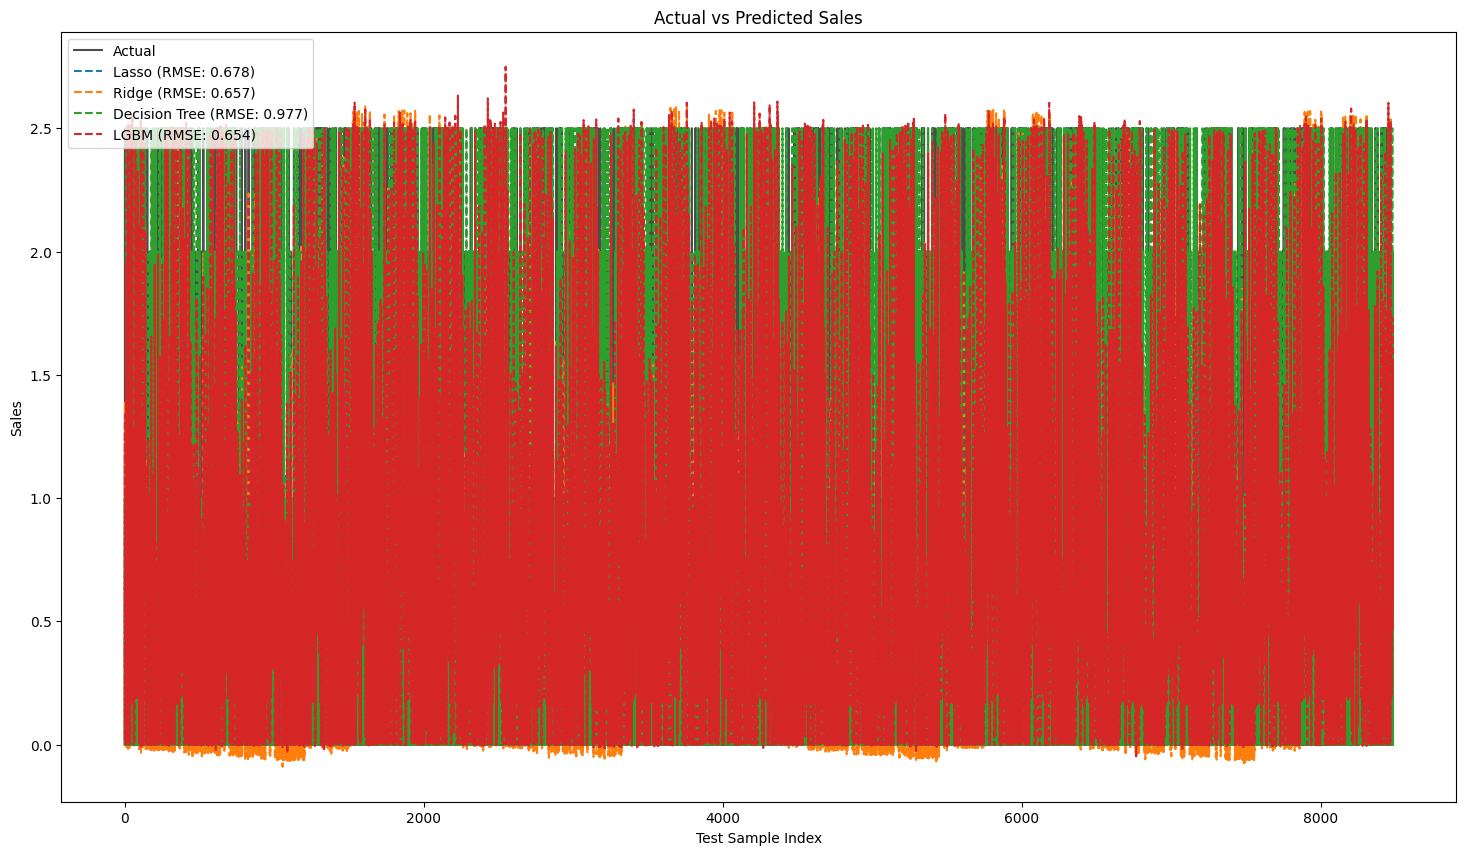

In [ ]:
plt.figure(figsize=(18, 10))

plt.plot(y_test['sold'].values, label='Actual', color='black', alpha=0.7)
plt.plot(y_pred_lasso_before, label='Lasso (RMSE: {:.3f})'.format(np.sqrt(mean_squared_error(y_test['sold'], y_pred_lasso_before))), linestyle='--')

plt.plot(y_pred_ridge_before, label='Ridge (RMSE: {:.3f})'.format(np.sqrt(mean_squared_error(y_test['sold'], y_pred_ridge_before))), linestyle='--')

plt.plot(y_pred_tree_before, label='Decision Tree (RMSE: {:.3f})'.format(np.sqrt(mean_squared_error(y_test['sold'], y_pred_tree_before))), linestyle='--')

plt.plot(y_pred_lgbm_before, label='LGBM (RMSE: {:.3f})'.format(np.sqrt(mean_squared_error(y_test['sold'], y_pred_lgbm_before))), linestyle='--')

plt.title('Actual vs Predicted Sales')
plt.xlabel('Test Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.show()


We compared predicted and Actual results and we can clearly see LGBM followed by Ridge and Lasso have better accuracy, Decision tree is comparatively less better.

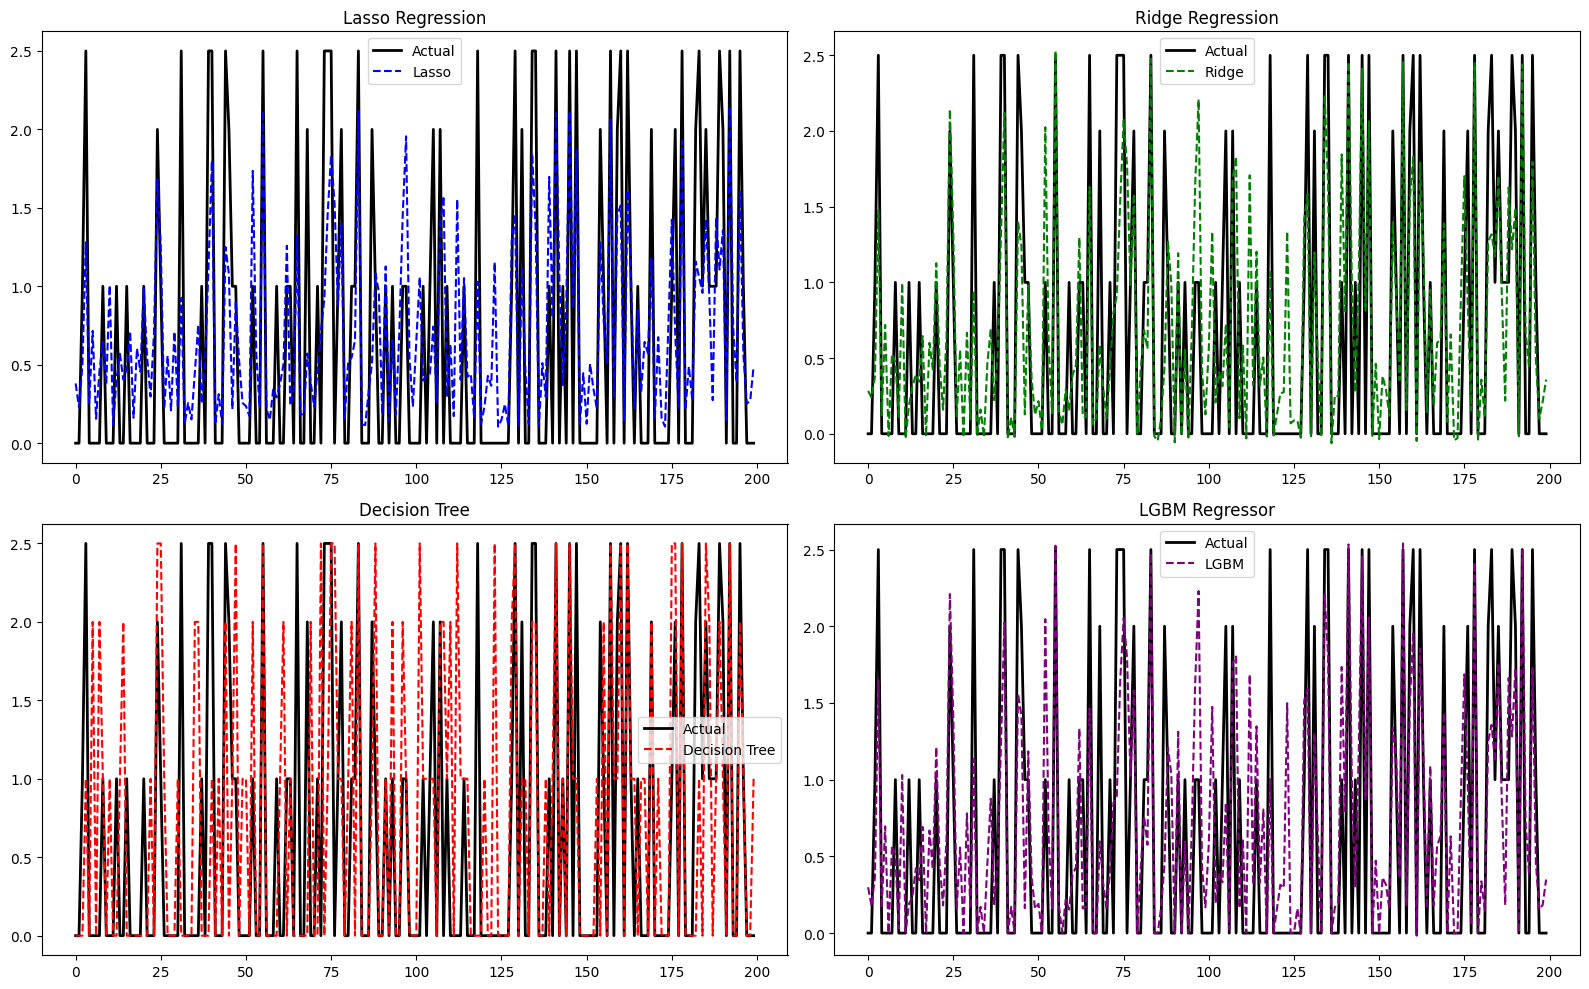

In [ ]:
%matplotlib inline
sample_size = 200
sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)

y_actual_sample = y_test['sold'].iloc[sample_indices].values

y_lasso_sample = y_pred_lasso_before[sample_indices]
y_ridge_sample = y_pred_ridge_before[sample_indices]
y_tree_sample = y_pred_tree_before[sample_indices]
y_lgbm_sample = y_pred_lgbm_before[sample_indices]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

axes[0].plot(y_actual_sample, label='Actual', color='black', linewidth=2)
axes[0].plot(y_lasso_sample, label='Lasso', linestyle='--', color='blue')
axes[0].set_title('Lasso Regression')
axes[0].legend()


axes[1].plot(y_actual_sample, label='Actual', color='black', linewidth=2)
axes[1].plot(y_ridge_sample, label='Ridge', linestyle='--', color='green')
axes[1].set_title('Ridge Regression')
axes[1].legend()

axes[2].plot(y_actual_sample, label='Actual', color='black', linewidth=2)
axes[2].plot(y_tree_sample, label='Decision Tree', linestyle='--', color='red')
axes[2].set_title('Decision Tree')
axes[2].legend()

axes[3].plot(y_actual_sample, label='Actual', color='black', linewidth=2)
axes[3].plot(y_lgbm_sample, label='LGBM', linestyle='--', color='purple')
axes[3].set_title('LGBM Regressor')
axes[3].legend()

plt.tight_layout()
plt.show()


For Hyperparameter tuning, i have used RandomizedSearchCV , beacause it is simple and effective. it samples from defined grids and it gives an excellent balance between computational efficiency and tuning quality compared to GridsearchCV.

I have did comparision on their performance and time take with standard metrics along with graph.

I have used parameters like Alpha for lasso and Ridge regression and nm_leaves,max_depth,learning_rate,n_estimators for LGBM

In [ ]:

def rmsse(y_true, y_pred, y_train):
    n = len(y_train)
    denominator = np.mean(np.diff(y_train.values.ravel())**2)
    numerator = mean_squared_error(y_true, y_pred)
    return np.sqrt(numerator / denominator)

def calculate_metrics(y_true, y_pred, y_train=None):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    rmsse_value = None
    if y_train is not None:
        rmsse_value = rmsse(y_true, y_pred, y_train)

    return mse, rmse, mae, r2, rmsse_value

def tune_and_evaluate(model, param_grid, x_train, y_train, x_test, y_test, model_name):
    search = RandomizedSearchCV(model, param_grid,
                                n_iter=len(param_grid[list(param_grid.keys())[0]]),
                                cv=5, scoring='neg_mean_squared_error',
                                random_state=42)
    search.fit(x_train, y_train.values.ravel())
    best_model = search.best_estimator_

    y_pred = best_model.predict(x_test)

    mse, rmse, mae, r2, rmsse_value = calculate_metrics(y_test['sold'], y_pred, y_train['sold'])

    print(f"{model_name}")
    print("Best Parameters:", search.best_params_)
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"RMSSE: {rmsse_value:.4f}")

    return best_model, y_pred


In [ ]:
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
best_lasso, y_pred_lasso = tune_and_evaluate(Lasso(), lasso_params, x_train, y_train, x_test, y_test, "Lasso Regression")

Lasso Regression
Best Parameters: {'alpha': 0.001}
MSE: 0.4316
RMSE: 0.6570
MAE: 0.4835
R^2: 0.5219
RMSSE: 0.5356


In [ ]:
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 80, 100]}
best_ridge, y_pred_ridge = tune_and_evaluate(Ridge(), ridge_params, x_train, y_train, x_test, y_test, "Ridge Regression")


Ridge Regression
Best Parameters: {'alpha': 0.1}
MSE: 0.4315
RMSE: 0.6568
MAE: 0.4831
R^2: 0.5221
RMSSE: 0.5356


In [ ]:
lgbm_params = {
    'num_leaves': [15, 33, 100],
    'max_depth': [1, 5, 25, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500]
}
best_lgbm, y_pred_lgbm = tune_and_evaluate(LGBMRegressor(), lgbm_params, x_train, y_train, x_test, y_test, "LGBM Regressor")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 406747, number of used features: 27
[LightGBM] [Info] Start training from score 0.575386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

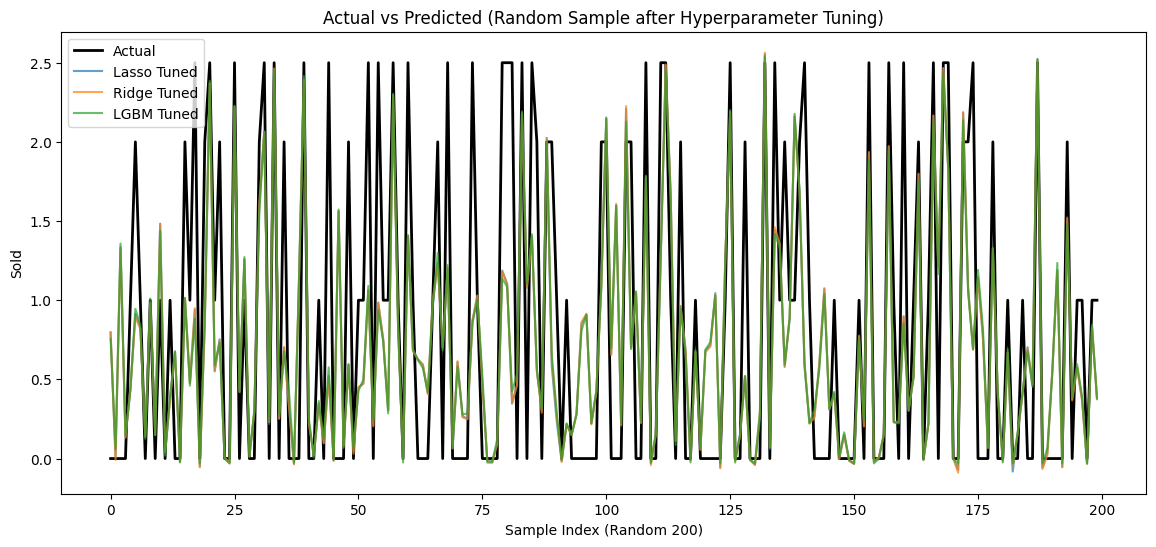

In [ ]:
%matplotlib inline
sample_size = 200
np.random.seed(42)
sample_indices = np.random.choice(y_test.index, size=sample_size, replace=False)

y_actual_sample = y_test.loc[sample_indices, 'sold'].values
y_lasso_sample = y_pred_lasso[sample_indices - y_test.index.min()]
y_ridge_sample = y_pred_ridge[sample_indices - y_test.index.min()]
y_lgbm_sample = y_pred_lgbm[sample_indices - y_test.index.min()]

plt.figure(figsize=(14,6))
plt.plot(y_actual_sample, label='Actual', color='black', linewidth=2)
plt.plot(y_lasso_sample, label='Lasso Tuned', alpha=0.7)
plt.plot(y_ridge_sample, label='Ridge Tuned', alpha=0.7)
plt.plot(y_lgbm_sample, label='LGBM Tuned', alpha=0.7)
plt.xlabel('Sample Index (Random 200)')
plt.ylabel('Sold')
plt.title('Actual vs Predicted (Random Sample after Hyperparameter Tuning)')
plt.legend()
plt.show()


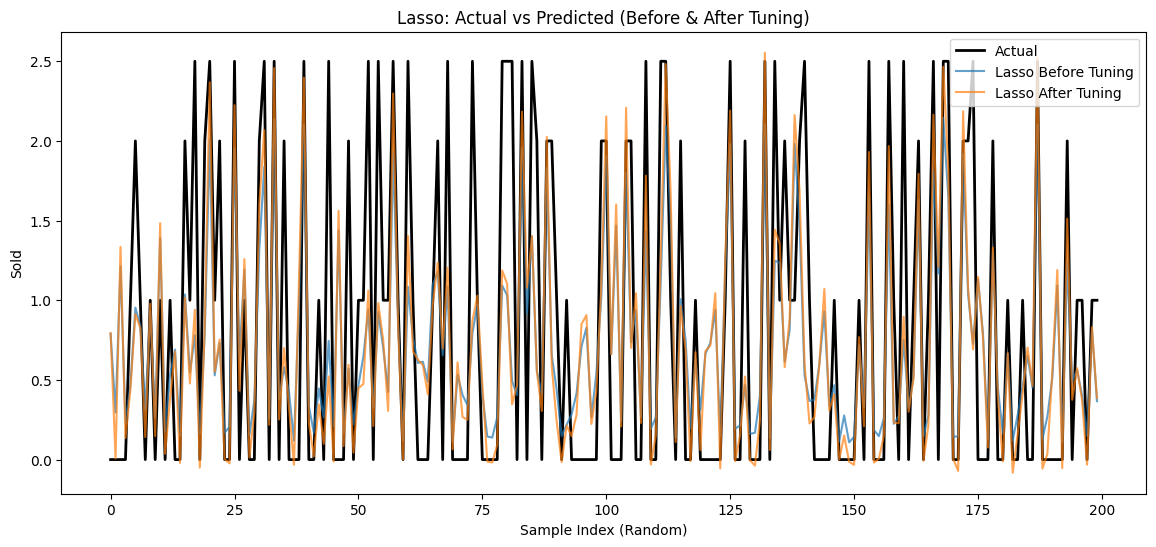

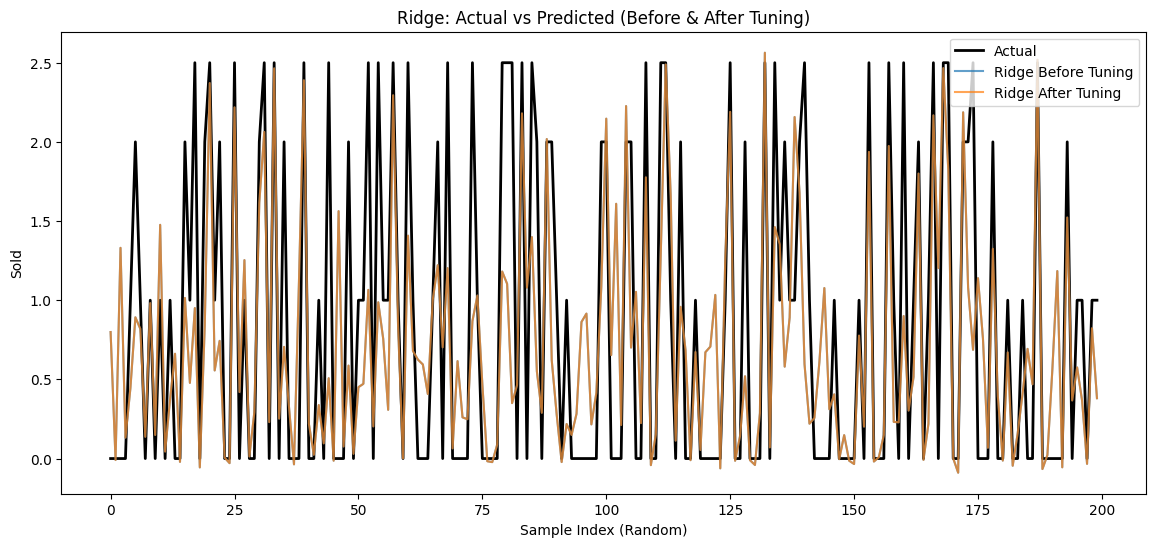

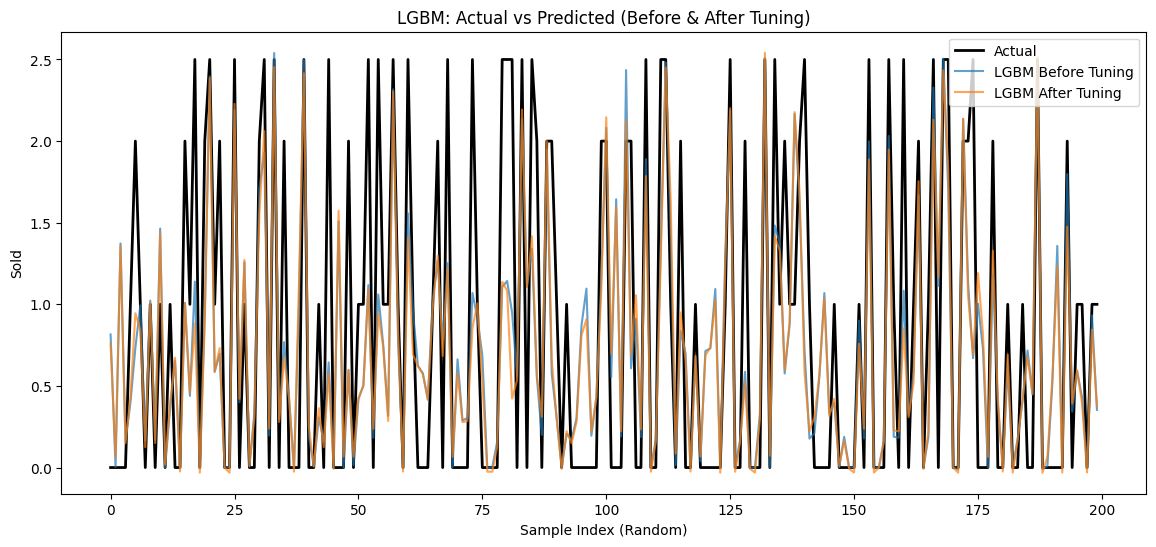

In [ ]:
%matplotlib inline
sample_size = 200
np.random.seed(42)
sample_indices = np.random.choice(y_test.index, size=sample_size, replace=False)

def plot_model_comparison(y_actual, y_pred_before, y_pred_after, model_name):
    plt.figure(figsize=(14,6))
    plt.plot(y_actual, label='Actual', color='black', linewidth=2)
    plt.plot(y_pred_before, label=f'{model_name} Before Tuning', alpha=0.7)
    plt.plot(y_pred_after, label=f'{model_name} After Tuning', alpha=0.7)
    plt.xlabel('Sample Index (Random)')
    plt.ylabel('Sold')
    plt.title(f'{model_name}: Actual vs Predicted (Before & After Tuning)')
    plt.legend()
    plt.show()

y_actual_sample = y_test.loc[sample_indices, 'sold'].values

y_lasso_before_sample = y_pred_lasso_before[sample_indices - y_test.index.min()]
y_lasso_after_sample = y_pred_lasso[sample_indices - y_test.index.min()]
plot_model_comparison(y_actual_sample, y_lasso_before_sample, y_lasso_after_sample, 'Lasso')

y_ridge_before_sample = y_pred_ridge_before[sample_indices - y_test.index.min()]
y_ridge_after_sample = y_pred_ridge[sample_indices - y_test.index.min()]
plot_model_comparison(y_actual_sample, y_ridge_before_sample, y_ridge_after_sample, 'Ridge')

y_lgbm_before_sample = y_pred_lgbm_before[sample_indices - y_test.index.min()]
y_lgbm_after_sample = y_pred_lgbm[sample_indices - y_test.index.min()]
plot_model_comparison(y_actual_sample, y_lgbm_before_sample, y_lgbm_after_sample, 'LGBM')


We can see improvement in accuracy after hyperparameter tuning, and LGBM is more closer to actual values amoong all models.

##Evaluation Metrics Used
* MSE - Mean squared error , it measures the average square difference between predicted andd actual values
* RMSE - Root mean squared error, square root of MSE, helps in interpreting error in actual scale
* MAE - Mean absolute error, gives average absolute deviation between prediction and actual values.
* R square - Indicates the goodness of fit and predictive ability
* RMSSE - Root mean squared scaled error, tracks accracy relative to historical variation, good for time series data.

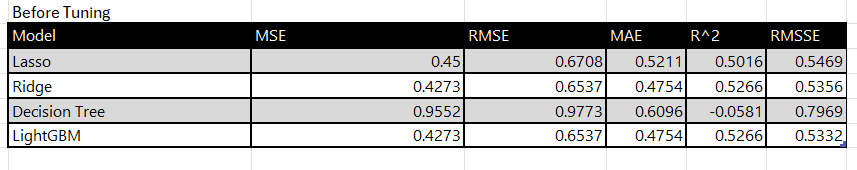

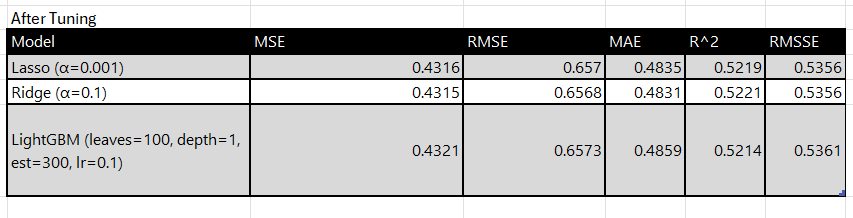

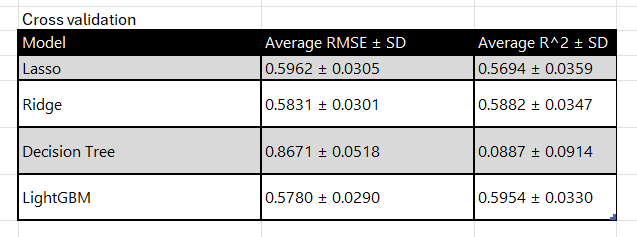

Result Analysis:

Both the Ridge and LightGBM methods produced the overall lowest cross-validation errors and achieved the greatest R^2, suggesting that both models generalize strongly.The Decision Tree had variable fold performance that indicates it overfit the training data as a consequence of the depth of the tree not being constrained.

Fitting Check:
Decision Tree: Overfit (train RMSE < test RMSE and negative R^2), therefore the model was corrected with LightGBM which worked to regularize and the max_depth was shallow (max_depth=1).

Lasso/Ridge: Worked to address overfitting using L1 (Lasso) and L2 (Ridge) regularization terms on coefficients.

LightGBM: LightGBM, similar to Lasso and Ridge, also worked to reduce the overfitting as it used hyperparameters such as max_depth and the rate of learning was set to low at 0.1.

The bias-variance tradeoff was taken into account as models improved with tuning and cross-validations.

Regularization
Lasso Regression (L1): Lasso shrinks coefficients to zero on some select coefficients, thus achieving implicit feature selection.

Ridge Regression (L2): Ridge shrinks coefficients and provides a penalty for coefficients greater than zero, which down-sizes amt of complexity incurred by the more than zero coefficients.

LightGBM: Although LightGBM doesn't use regularization to manage the overfitting, it does use hyperparameters such as the max_depth and the rate of learning, which can also be thought of as an implicit penalty similar to L2.

About not having Cross-Validation and having Cross-Validation
No CV: The single split that is inherent to the analysis entails a level of bias into the testing results.Using CV: TimeSeriesSplit appeared to derive a much more accurate performance estimate with less variance accounting for opportunity to be consistent with model across multiple forecasting periods.

About not having Hyperparameter tuning and having Hyperparameter tuning Without tuning: There was a greater spread in both the normal RMSE and the normal R^2. Decision Trees had the worst performance out of all the models. With tuning: After tuning, all of the four models appeared to converge to approximately 0.65 and the normal R^2 converged to ranges between approximately 0.52 and 0.59 which is being validated increases in performance against consistency and generalizability.

Ridge Regression: Grid Search
Best Params: {'alpha': 0.01, 'solver': 'svd'}
Time Taken: 1852.66 seconds
MSE: 0.4315
RMSE: 0.6568
MAE: 0.4831
R^2: 0.5221
RMSSE: 0.5356
Ridge Regression: Randomized Search
Best Params: {'solver': 'auto', 'alpha': 0.1}
Time Taken: 226.49 seconds
MSE: 0.4315
RMSE: 0.6568
MAE: 0.4831
R^2: 0.5221
RMSSE: 0.5356


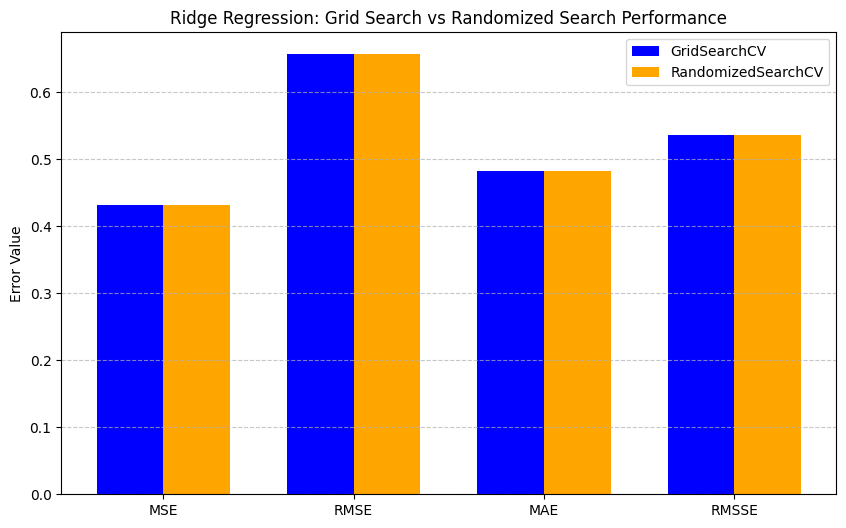

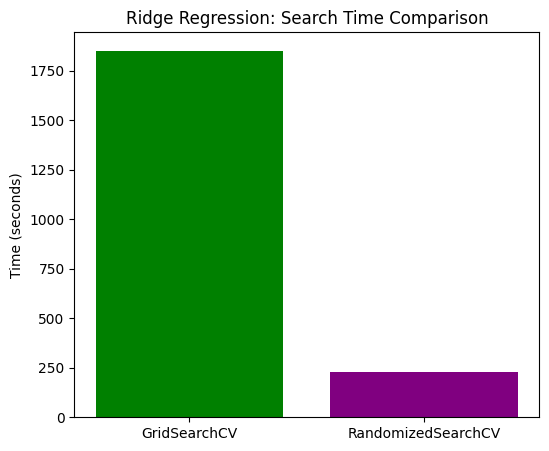

In [ ]:
%matplotlib inline
def rmsse(y_true, y_pred, y_train):
    n = len(y_train)
    denominator = np.mean(np.diff(y_train.values.ravel())**2)
    numerator = mean_squared_error(y_true, y_pred)
    return np.sqrt(numerator / denominator)


def calculate_metrics(y_true, y_pred, y_train=None):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    rmsse_value = None
    if y_train is not None:
        rmsse_value = rmsse(y_true, y_pred, y_train)

    return mse, rmse, mae, r2, rmsse_value


param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}


grid_search = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

start_time = time.time()
grid_search.fit(x_train, y_train.values.ravel())
grid_time = time.time() - start_time

best_grid = grid_search.best_estimator_
y_pred_grid = best_grid.predict(x_test)

mse_g, rmse_g, mae_g, r2_g, rmsse_g = calculate_metrics(y_test['sold'], y_pred_grid, y_train['sold'])

print("Ridge Regression: Grid Search")
print("Best Params:", grid_search.best_params_)
print(f"Time Taken: {grid_time:.2f} seconds")
print(f"MSE: {mse_g:.4f}")
print(f"RMSE: {rmse_g:.4f}")
print(f"MAE: {mae_g:.4f}")
print(f"R^2: {r2_g:.4f}")
print(f"RMSSE: {rmsse_g:.4f}")


random_search = RandomizedSearchCV(
    estimator=Ridge(),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(x_train, y_train.values.ravel())
random_time = time.time() - start_time

best_random = random_search.best_estimator_
y_pred_random = best_random.predict(x_test)

mse_r, rmse_r, mae_r, r2_r, rmsse_r = calculate_metrics(y_test['sold'], y_pred_random, y_train['sold'])

print("Ridge Regression: Randomized Search")
print("Best Params:", random_search.best_params_)
print(f"Time Taken: {random_time:.2f} seconds")
print(f"MSE: {mse_r:.4f}")
print(f"RMSE: {rmse_r:.4f}")
print(f"MAE: {mae_r:.4f}")
print(f"R^2: {r2_r:.4f}")
print(f"RMSSE: {rmsse_r:.4f}")


metrics = ['MSE', 'RMSE', 'MAE', 'RMSSE']
grid_values = [mse_g, rmse_g, mae_g, rmsse_g]
random_values = [mse_r, rmse_r, mae_r, rmsse_r]

plt.figure(figsize=(10,6))
x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, grid_values, width, label='GridSearchCV', color='blue')
plt.bar(x + width/2, random_values, width, label='RandomizedSearchCV', color='orange')

plt.ylabel('Error Value')
plt.title('Ridge Regression: Grid Search vs Randomized Search Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize=(6,5))
plt.bar(['GridSearchCV', 'RandomizedSearchCV'], [grid_time, random_time], color=['green', 'purple'])
plt.ylabel('Time (seconds)')
plt.title('Ridge Regression: Search Time Comparison')
plt.show()


Lasso Regression: Grid Search
Best Params: {'alpha': 0.001, 'max_iter': 500}
Time Taken: 90.95 seconds
MSE: 0.4316
RMSE: 0.6570
MAE: 0.4835
R^2: 0.5219
RMSSE: 0.5356

Lasso Regression: Randomized Search
Best Params: {'max_iter': 500, 'alpha': 0.001}
Time Taken: 26.73 seconds
MSE: 0.4316
RMSE: 0.6570
MAE: 0.4835
R^2: 0.5219
RMSSE: 0.5356



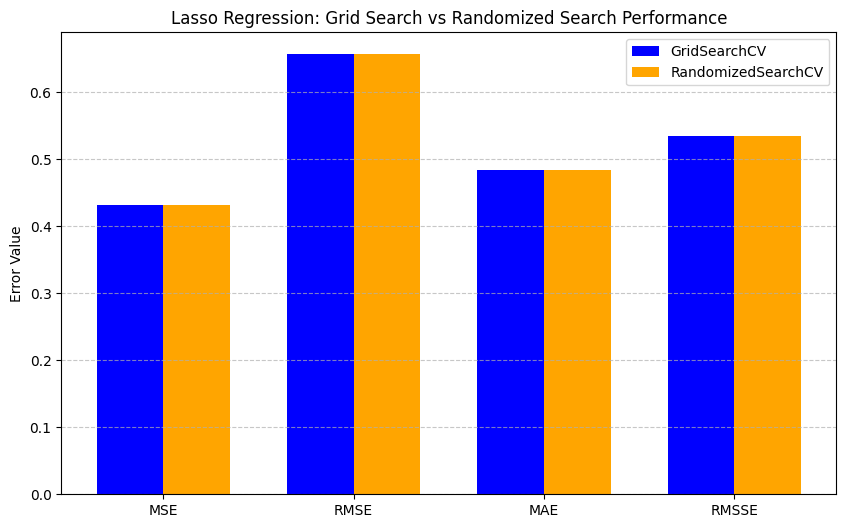

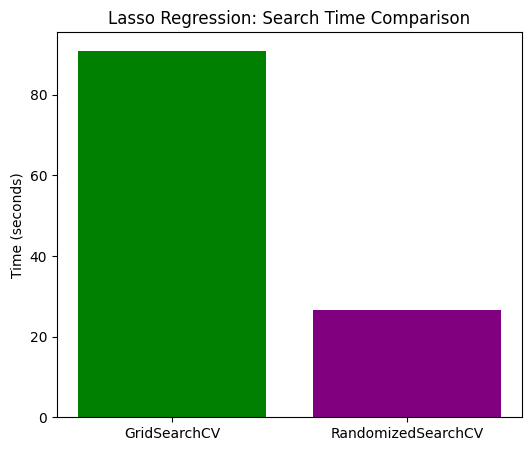

In [ ]:
%matplotlib inline

def rmsse(y_true, y_pred, y_train):
    n = len(y_train)
    denominator = np.mean(np.diff(y_train.values.ravel())**2)
    numerator = mean_squared_error(y_true, y_pred)
    return np.sqrt(numerator / denominator)


def calculate_metrics(y_true, y_pred, y_train=None):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    rmsse_value = None
    if y_train is not None:
        rmsse_value = rmsse(y_true, y_pred, y_train)

    return mse, rmse, mae, r2, rmsse_value


param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200],
    'max_iter': [500, 1000, 2000, 3000]
}


grid_search = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

start_time = time.time()
grid_search.fit(x_train, y_train.values.ravel())
grid_time = time.time() - start_time

best_grid = grid_search.best_estimator_
y_pred_grid = best_grid.predict(x_test)

mse_g, rmse_g, mae_g, r2_g, rmsse_g = calculate_metrics(y_test['sold'], y_pred_grid, y_train['sold'])

print("Lasso Regression: Grid Search")
print("Best Params:", grid_search.best_params_)
print(f"Time Taken: {grid_time:.2f} seconds")
print(f"MSE: {mse_g:.4f}")
print(f"RMSE: {rmse_g:.4f}")
print(f"MAE: {mae_g:.4f}")
print(f"R^2: {r2_g:.4f}")
print(f"RMSSE: {rmsse_g:.4f}\n")


random_search = RandomizedSearchCV(
    estimator=Lasso(),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(x_train, y_train.values.ravel())
random_time = time.time() - start_time

best_random = random_search.best_estimator_
y_pred_random = best_random.predict(x_test)

mse_r, rmse_r, mae_r, r2_r, rmsse_r = calculate_metrics(y_test['sold'], y_pred_random, y_train['sold'])

print("Lasso Regression: Randomized Search")
print("Best Params:", random_search.best_params_)
print(f"Time Taken: {random_time:.2f} seconds")
print(f"MSE: {mse_r:.4f}")
print(f"RMSE: {rmse_r:.4f}")
print(f"MAE: {mae_r:.4f}")
print(f"R^2: {r2_r:.4f}")
print(f"RMSSE: {rmsse_r:.4f}\n")


metrics = ['MSE', 'RMSE', 'MAE', 'RMSSE']
grid_values = [mse_g, rmse_g, mae_g, rmsse_g]
random_values = [mse_r, rmse_r, mae_r, rmsse_r]

plt.figure(figsize=(10,6))
x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, grid_values, width, label='GridSearchCV', color='blue')
plt.bar(x + width/2, random_values, width, label='RandomizedSearchCV', color='orange')
plt.ylabel('Error Value')
plt.title('Lasso Regression: Grid Search vs Randomized Search Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(6,5))
plt.bar(['GridSearchCV', 'RandomizedSearchCV'], [grid_time, random_time], color=['green', 'purple'])
plt.ylabel('Time (seconds)')
plt.title('Lasso Regression: Search Time Comparison')
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.245539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 508434, number of used features: 27
[LightGBM] [Info] Start training from score 0.543384
LGBMRegressor: Grid Search
Best Params: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31}
Time Taken: 695.86 seconds
MSE: 0.4271
RMSE: 0.6535
MAE: 0.4771
R^2: 0.5269
RMSSE: 0.5332

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 508434, number of used features: 27
[LightGBM] [Info] Start trai

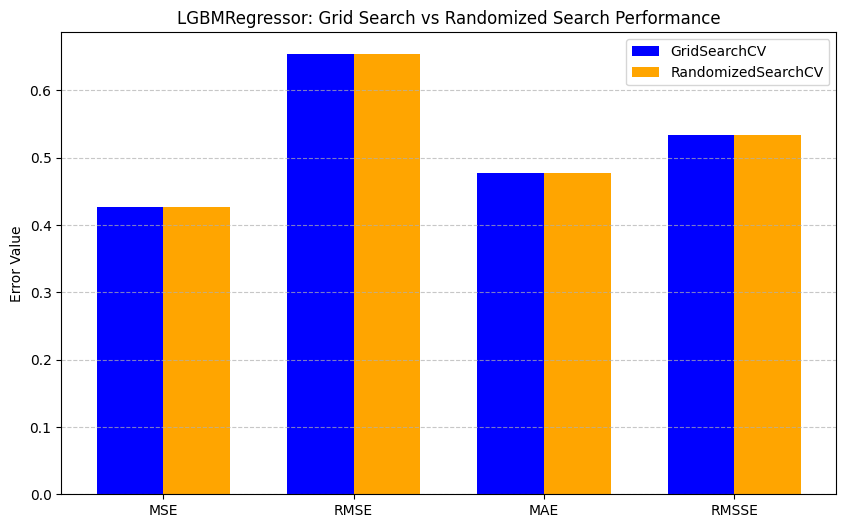

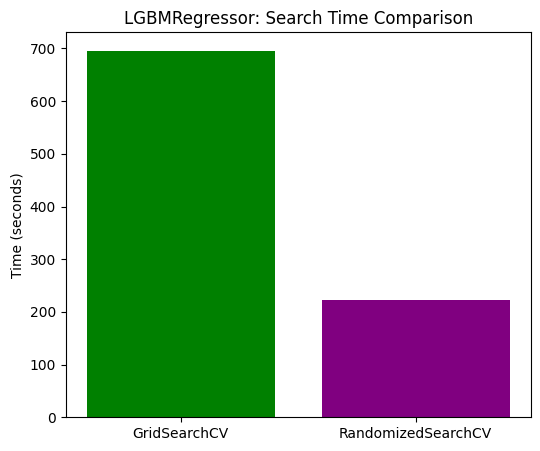

In [ ]:
%matplotlib inline
def rmsse(y_true, y_pred, y_train):
    n = len(y_train)
    denominator = np.mean(np.diff(y_train.values.ravel())**2)
    numerator = mean_squared_error(y_true, y_pred)
    return np.sqrt(numerator / denominator)


def calculate_metrics(y_true, y_pred, y_train=None):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    rmsse_value = None
    if y_train is not None:
        rmsse_value = rmsse(y_true, y_pred, y_train)

    return mse, rmse, mae, r2, rmsse_value


param_grid = {
    'num_leaves': [15, 31],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300]
}


grid_search = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

start_time = time.time()
grid_search.fit(x_train, y_train.values.ravel())
grid_time = time.time() - start_time

best_grid = grid_search.best_estimator_
y_pred_grid = best_grid.predict(x_test)

mse_g, rmse_g, mae_g, r2_g, rmsse_g = calculate_metrics(y_test['sold'], y_pred_grid, y_train['sold'])

print("LGBMRegressor: Grid Search")
print("Best Params:", grid_search.best_params_)
print(f"Time Taken: {grid_time:.2f} seconds")
print(f"MSE: {mse_g:.4f}")
print(f"RMSE: {rmse_g:.4f}")
print(f"MAE: {mae_g:.4f}")
print(f"R^2: {r2_g:.4f}")
print(f"RMSSE: {rmsse_g:.4f}\n")


random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(),
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(x_train, y_train.values.ravel())
random_time = time.time() - start_time

best_random = random_search.best_estimator_
y_pred_random = best_random.predict(x_test)

mse_r, rmse_r, mae_r, r2_r, rmsse_r = calculate_metrics(y_test['sold'], y_pred_random, y_train['sold'])

print("LGBMRegressor: Randomized Search")
print("Best Params:", random_search.best_params_)
print(f"Time Taken: {random_time:.2f} seconds")
print(f"MSE: {mse_r:.4f}")
print(f"RMSE: {rmse_r:.4f}")
print(f"MAE: {mae_r:.4f}")
print(f"R^2: {r2_r:.4f}")
print(f"RMSSE: {rmsse_r:.4f}\n")

metrics = ['MSE', 'RMSE', 'MAE', 'RMSSE']
grid_values = [mse_g, rmse_g, mae_g, rmsse_g]
random_values = [mse_r, rmse_r, mae_r, rmsse_r]

plt.figure(figsize=(10,6))
x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, grid_values, width, label='GridSearchCV', color='blue')
plt.bar(x + width/2, random_values, width, label='RandomizedSearchCV', color='orange')
plt.ylabel('Error Value')
plt.title('LGBMRegressor: Grid Search vs Randomized Search Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(6,5))
plt.bar(['GridSearchCV', 'RandomizedSearchCV'], [grid_time, random_time], color=['green', 'purple'])
plt.ylabel('Time (seconds)')
plt.title('LGBMRegressor: Search Time Comparison')
plt.show()


We can see from above visuals that RandomizedSearch produce same results as GridSearchCV but time taken for execution is comparatively very fast.

#Final Analysis:

### Learnings:
* We have incoporated features such as lagged sales, rolling means, and calendar events (holidays, snap days) significantly improves time series sales forecasting.
* Regularization (Lasso and Ridge) helps in linear model generalization by reducing overfitting.
* By using gradient boosting (LightGBM), a very good accuracy can be achieved. This model can handle nonlinear data and complex variable dependencies way better than simple tree or linear models.
* Decision Trees that are not tuned overfit and have a low performance and less preferred with data like this.
* Cross-validation helps to understabd the performance variation and generalization across different train-test split.

### Patterns:
* One of the most striking seasonal patterns is the drop of sales at Christmas for all stores.
* sales are also dependent on categorical factors such as state and store, with California having the highest sales overall.
* An in-depth correlation analysis revealed that the multicollinearity was among rolling means and lags, thus requiring that features be filtered.
* Model metrics are always better with hyperparameter tuning, thus the difference in model performance is reduced significantly.
* Both LightGBM and Ridge are in most cases better than Lasso.

### Results:
* significant aspects of time being, cyclical, and promotional influences in sales data can be addressed by means of preprocessing and feature engineering.
* Here Accuracy got increased significantly and variance greatly reduced as, a result of, model tuning, especially when the models in question are tree-based.

### Conclusion:

In general, the forecasting models, and namely the LightGBM ones featuring tuned parameters, are well equipped to exploit the engineered features of the extensive calendar and sales data and, by doing so, are able to make reasonably accurate predictions of retail FMCG sales. Along with that, Regularization and hyperparameter tuning improve generalization and reduces overfitting. Time series cross-validation is a method that deals with different temporal segments and at the same time it confirms model reliability. This implementation helps to understand what it takes to be reliable in the field of forecasting: combining domain-oriented feature development, model regularization, and dynamic evaluation.
